In [1293]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import pycountry
import pycountry_convert as pc
import geopandas as gpd
from descartes.patch import PolygonPatch
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, KFold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib as mpl
from xgboost import XGBClassifier
from statistics import mean
from pandas.plotting import scatter_matrix
from scipy import stats  
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
from sklearn.linear_model import LogisticRegression
import itertools
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

## Reading Data

In [170]:
# data_loc = os.path.join(os.getcwd(), 'Dataset', 'data.csv')
# df = pd.read_csv(data_loc)
df = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2021-2022/spotify/data.csv.zip')

# Explore how artists and tracks’ popularity varies in time across the global stage

##  1.Do regions share the same top-ranking artists or songs?
##  2.Does the popularity of a track in one region predict its (upcoming?) popularity in other regions ?
##  3.Are there any patterns in what day(s) of the week and/or months experience the most streams? 
##  4.Does reaching the top N (e.g., 5, 10, 20) positions have any relationship with the subsequent lifetime of a track in the data?
##  5.Are there any patterns in what day(s) of the week and/or months experience the most streams?Do these patterns, if any, differ by region?
##  6.Take a ‘deep-dive’ into the work of one (or a collection of) artist(s) and examine trends across their apparent most popular tracks.

# Exploratory Data Analysis (EDA)

## Data Cleaning & Wrangling

### Data Cleaning

In [171]:
# Drop NaN values
df.dropna(subset=['Track Name', 'Artist'], how='all', inplace=True)

# Drop unused column 'URL'
df.drop(columns='URL', inplace=True)

df

Position                  Track Name              Artist  Streams  \
0               1  Reggaetón Lento (Bailemos)                CNCO    19272   
1               2                    Chantaje             Shakira    19270   
2               3   Otra Vez (feat. J Balvin)       Zion & Lennox    15761   
3               4                Vente Pa' Ca        Ricky Martin    14954   
4               5                      Safari            J Balvin    14269   
...           ...                         ...                 ...      ...   
3441192       196          More Than You Know  Axwell /\ Ingrosso     2126   
3441193       197                      Issues      Julia Michaels     2117   
3441194       198                 Tuo Fei Lun          Eason Chan     2112   
3441195       199                          面具          Alfred Hui     2102   
3441196       200                  Let Her Go           Passenger     2088   

               Date Region  
0        2017-01-01     ec  
1        2017-01-01     ec  
2        2017-01-01     ec  
3        2017-01-01     ec  
4        2017-01-01     ec  
...             ...    ...  
3441192  2018-01-09     hk  
3441193  2018-01-09     hk  
3441194  2018-01-09     hk  
3441195  2018-01-09     hk  
3441196  2018-01-09     hk  

[3440540 rows x 6 columns]

### Data Wrangling

In [172]:
# Change date column to date type
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Turn 'Date' column into three columns 'Year', 'Month', 'Weekday'  
df['Year'] = pd.DatetimeIndex(df.Date).year
df['Month'] = pd.DatetimeIndex(df.Date).month
df['Weekday'] = df['Date'].dt.day_name()

In [173]:
# Convert region codes to corresponding full names
df['Region Code'] = df['Region'].str.upper()

def getRegionName(region):
    if region == 'GLOBAL':
        return region.title()
    return pc.country_alpha2_to_country_name(region,cn_name_format="default")

def getContinentName(region):
    if region == 'GLOBAL':
        return region.title()
    return pc.country_alpha2_to_continent_code(region)

df['Continent'] = df['Region Code'].apply(getContinentName)
df['Region'] = df['Region Code'].apply(getRegionName)

# Replace the abbreviation of continent with corresponding full names
df['Continent'] = df['Continent'].replace({'AS':'Asia', 'EU':'Europe', 'NA':'North America',
                                          'OC':'Oceania','SA':'South America'})

# Reduce the length of some region names
df['Region'] = df['Region'].replace({'Bolivia, Plurinational State of':'Bolivia', 
                                     'Taiwan, Province of China':'Taiwan',
                                     'United States':'United States of America'})

In [400]:
df

Position                  Track Name              Artist  Streams  \
0               1  Reggaetón Lento (Bailemos)                CNCO    19272   
1               2                    Chantaje             Shakira    19270   
2               3   Otra Vez (feat. J Balvin)       Zion & Lennox    15761   
3               4                Vente Pa' Ca        Ricky Martin    14954   
4               5                      Safari            J Balvin    14269   
...           ...                         ...                 ...      ...   
3441192       196          More Than You Know  Axwell /\ Ingrosso     2126   
3441193       197                      Issues      Julia Michaels     2117   
3441194       198                 Tuo Fei Lun          Eason Chan     2112   
3441195       199                          面具          Alfred Hui     2102   
3441196       200                  Let Her Go           Passenger     2088   

              Date     Region  Year  Month  Weekday Region Code      Continent  
0       2017-01-01    Ecuador  2017      1   Sunday          EC  South America  
1       2017-01-01    Ecuador  2017      1   Sunday          EC  South America  
2       2017-01-01    Ecuador  2017      1   Sunday          EC  South America  
3       2017-01-01    Ecuador  2017      1   Sunday          EC  South America  
4       2017-01-01    Ecuador  2017      1   Sunday          EC  South America  
...            ...        ...   ...    ...      ...         ...            ...  
3441192 2018-01-09  Hong Kong  2018      1  Tuesday          HK           Asia  
3441193 2018-01-09  Hong Kong  2018      1  Tuesday          HK           Asia  
3441194 2018-01-09  Hong Kong  2018      1  Tuesday          HK           Asia  
3441195 2018-01-09  Hong Kong  2018      1  Tuesday          HK           Asia  
3441196 2018-01-09  Hong Kong  2018      1  Tuesday          HK           Asia  

[3440540 rows x 11 columns]

## Data Visualisation for EDA

<AxesSubplot:>

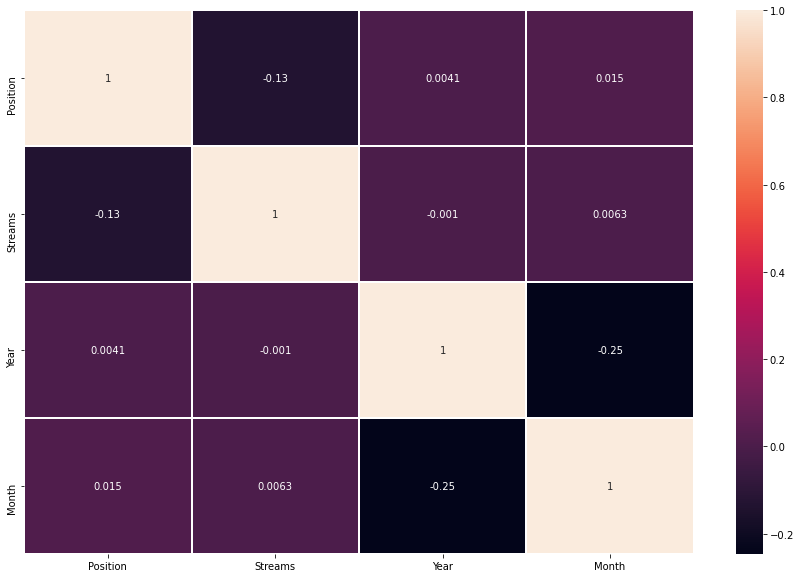

In [405]:
cols_list = df.columns.values.tolist()
cols_list
df_exp = df[cols_list]
plt.figure(figsize=(15,10))
sns.heatmap(df_exp.corr(), annot =True, linewidths = 1)

In [688]:
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_streams = df.groupby('Region')['Streams'].sum()
df_world_streams = df_world.merge(df_streams, how="left", left_on=['name'], right_on=['Region'])

Text(0.5, 1.0, 'Streams around the world')

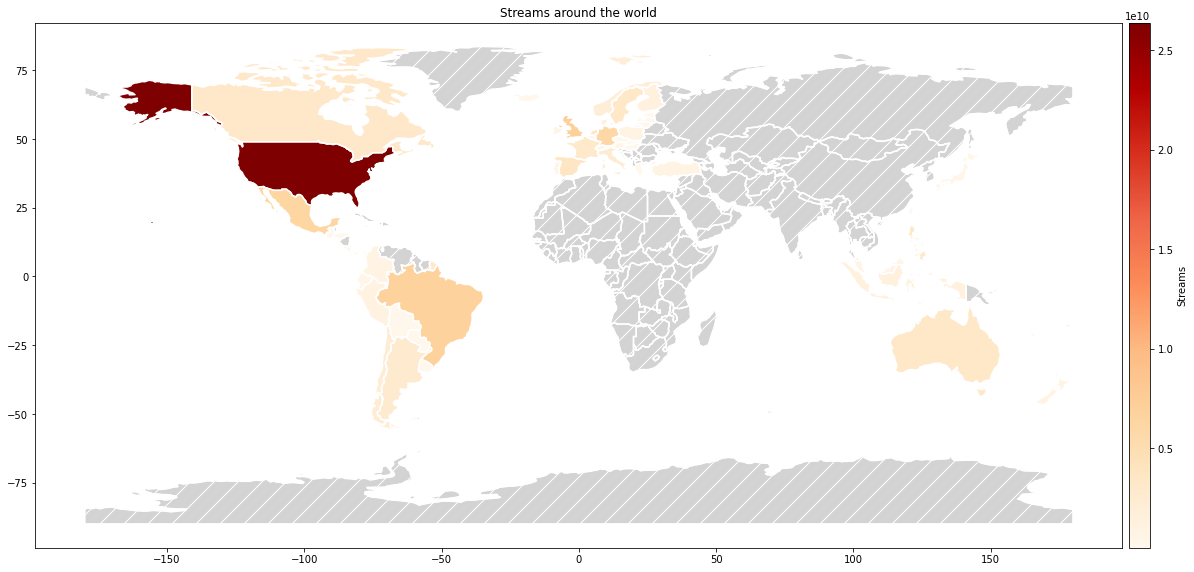

In [71]:
# As a first step, let’s plot the basic map – world with boundary only. 
# In the next steps, we will colour the countries that we are interested in.
ax = df_world["geometry"].boundary.plot(figsize=(20,16), color='white')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad="0.5%")
cax.set_ylabel('Streams')
df_world_streams.plot(column='Streams', ax=ax, cax=cax, cmap='OrRd', 
#                      scheme='quantiles',
                     legend=True, 
#                      legend_kwds={"labels": ['Streams','Streams','Streams','Streams','Streams']},
                     legend_kwds={"label": 'Streams'},
                     missing_kwds={'color': 'lightgrey',
                     "edgecolor": "white", "hatch": "/"})

ax.set_title("Streams around the world")

# Shading the countries that didn’t participate

<Figure size 720x720 with 0 Axes>

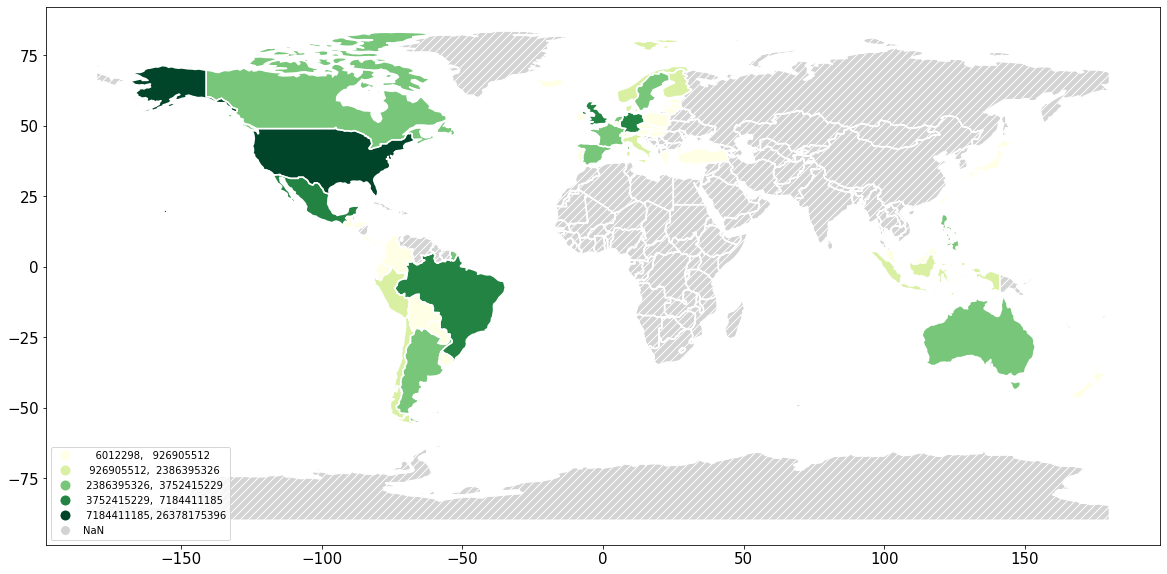

In [836]:
# As a first step, let’s plot the basic map – world with boundary only. 
# In the next steps, we will colour the countries that we are interested in.
# Shading the countries that didn’t participate

fig = plt.figure()
ax = df_world["geometry"].boundary.plot(figsize=(20,18), color='white')
divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="2%", pad="0.5%")
# cax.set_ylabel('Streams')
ax = df_world_streams.plot(column='Streams', ax=ax, 
#                      cax=cax, 
                     cmap='YlGn', 
                     scheme='fisher_jenks',
#                      k=10,
                     legend=True, 
#                      legend_kwds={'loc': 'lower left',
#                          "labels": [r'$<1.25x10^8$',
#                                     r'$\geq1.25x10^8$',
#                                     r'$\geq4.09x10^8$',
#                                     r'$\geq9.88x10^8$', 
#                                     r'$\geq3.22x10^9$']},
#                      legend_kwds={"label": 'Streams'},
                     legend_kwds={'loc': 'lower left','fmt':"{:.0f}"},
                     missing_kwds={'color': 'lightgrey',
                     "edgecolor": "white", "hatch": "///"})

ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)

# ax.legend(loc='center right', fontsize=35)
plt.savefig('../world_distribution.png', dpi = 100)

<Figure size 720x720 with 0 Axes>

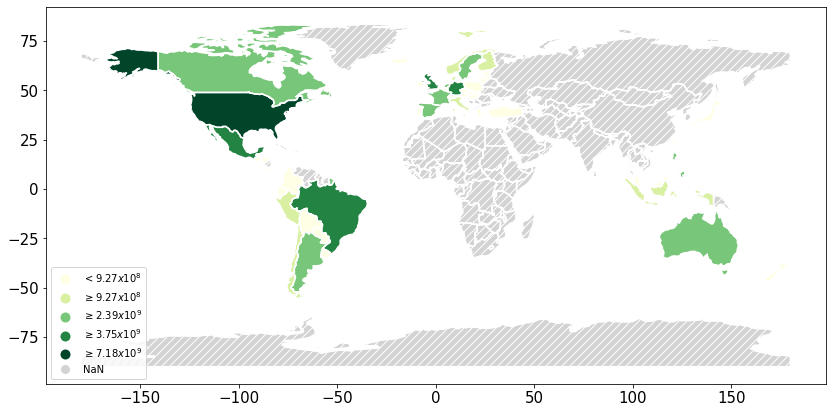

In [1370]:
# As a first step, let’s plot the basic map – world with boundary only. 
# In the next steps, we will colour the countries that we are interested in.
# Shading the countries that didn’t participate

fig = plt.figure()
ax = df_world["geometry"].boundary.plot(figsize=(14,12), color='white')
divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="2%", pad="0.5%")
# cax.set_ylabel('Streams')
ax = df_world_streams.plot(column='Streams', ax=ax, 
#                      cax=cax, 
                     cmap='YlGn', 
                     scheme='fisher_jenks',
#                      k=10,
                     legend=True, 
                     legend_kwds={'loc': 'lower left',
                         "labels": [r'$<9.27x10^8$',
                                    r'$\geq9.27x10^8$',
                                    r'$\geq2.39x10^9$',
                                    r'$\geq3.75x10^9$', 
                                    r'$\geq7.18x10^9$']},
#                      legend_kwds={"label": 'Streams'},
#                      legend_kwds={'loc': 'lower left','fmt':"{:.0f}"},
                     missing_kwds={'color': 'lightgrey',
                     "edgecolor": "white", "hatch": "///"})

ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)

# ax.legend(loc='center right', fontsize=35)
plt.savefig('../world_distribution.png', dpi = 100)

In [908]:
df_pie_data = df_streams.to_frame().drop('Global')
pct_value = df_pie_data[lambda x: x.columns[0]].quantile(0.8)
values_below_pct_value = df_pie_data[lambda x: x.columns[0]].loc[lambda s: s < pct_value].index.values
other_list = values_below_pct_value.tolist()
df_pie_data = df_pie_data.reset_index()
def fix_values(row):
    if row['Region'] in other_list:
        row['Region'] = 'Other'
    return row
df_pie_data = df_pie_data.apply(fix_values, axis=1).groupby('Region').agg('sum')
df_pie_data

Streams
Region                               
Argentina                  2775453630
Australia                  3371290725
Austria                     344237624
Belgium                     556653402
Bolivia                      97190104
Brazil                     6889016005
Canada                     3200384965
Chile                      2190201242
Colombia                    833665012
Costa Rica                  362660910
Czechia                     208541669
Denmark                    1509351202
Dominican Republic          153969017
Ecuador                     318288247
El Salvador                  80366800
Estonia                      21637719
Finland                    1245851940
France                     3145786676
Germany                    6071522245
Greece                       58752828
Guatemala                   176880565
Honduras                     91324507
Hong Kong                   295717291
Hungary                     152719207
Iceland                      80076801
Indonesia                  1286894693
Ireland                     648005661
Italy                      2386395326
Japan                       315830246
Latvia                       33640561
Lithuania                    30344862
Luxembourg                    6012298
Malaysia                    652084578
Mexico                     6341450674
Netherlands                3466573763
New Zealand                 813013377
Norway                     2010450147
Panama                      131400243
Paraguay                    167072124
Peru                       1078600550
Philippines                3320110220
Poland                      785105274
Portugal                    441094910
Singapore                   763574273
Slovakia                     42710374
Spain                      3752415229
Sweden                     3367055952
Switzerland                 486958763
Taiwan                      445766593
Turkey                      926905512
United Kingdom             7184411185
United States of America  26378175396
Uruguay                     194848876

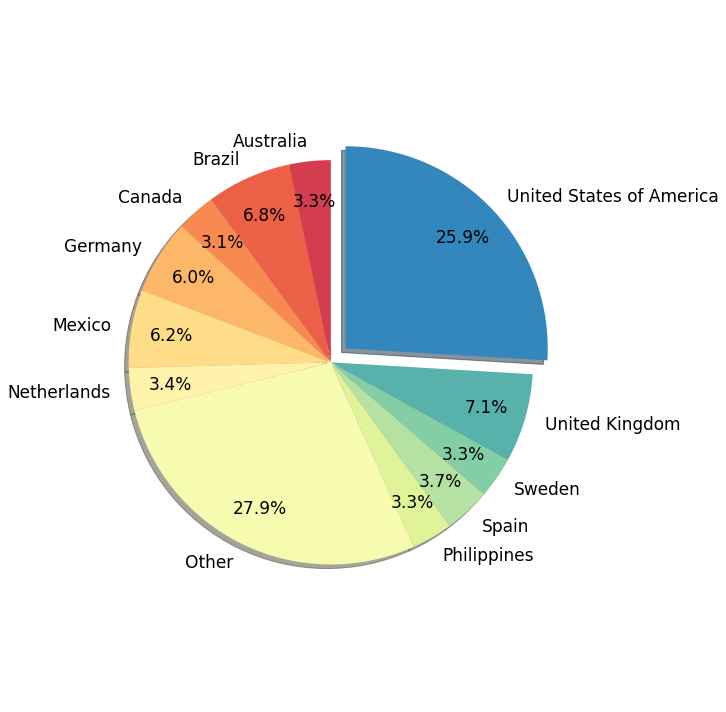

In [838]:
# Pie chart
labels = df_pie_data.index.tolist()
sizes = df_pie_data.Streams.tolist()
explode = tuple([0 if label != 'United States of America' else 0.1 for label in labels])
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0.1, 0.9, len(labels))]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors, 
        textprops={'fontsize': 17}, pctdistance=0.8)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.savefig('../pie_chart.png', dpi = 100)
plt.show()

In [534]:
df_2017 = df[df.Year != 2018]


In [548]:
len(set(df_2017['Track Name'].values.tolist()))

18286

## Extended Dataset

In [1325]:
data_loc = os.path.join(os.getcwd(), 'Dataset', 'Features.csv')
df_extended = pd.read_csv(data_loc)
df_extended.drop(
    columns= ['Unnamed: 0','analysis_url','id_caller','id_other','region','track_href', 'type','uri']
    , inplace=True)
df_extended

# Filter 2017 only
# df_extended = df_extended[df_extended.date.str.contains('2017', na=False)]

# Filter 2017 and 2018
df_extended = df_extended[df_extended.date.str.contains('2017', na=False) | 
                          df_extended.date.str.contains('2018', na=False)]

# Select All
# df_extended = df_extended[df_extended.date.str.contains('2017', na=False) | 
#                           df_extended.date.str.contains('2018', na=False) |
#                           df_extended.date.str.contains('2019', na=False)]

# Change the data type of columns
df_extended['Position'] = pd.to_numeric(df_extended['Position'])
df_extended['Streams'] = pd.to_numeric(df_extended['Streams'])
df_extended['Artist_Trackname'] = df_extended['Artist'] + ' - ' + df_extended['Track Name']

streams = df_extended.groupby('Artist_Trackname')['Streams'].unique()
positions = df_extended.groupby('Artist_Trackname')['Position'].unique()
# pd.DataFrame({'email':b.index, 'list':b.values})
# a.index.tolist() == b.index.tolist()

df_extended_uniq = pd.DataFrame({'Artist_Trackname':streams.index, 
                                 'Total Streams': [sum(lst) for lst in streams.values],
                                 'Average Position':[mean(lst) for lst in positions.values],
                                 'Highest Position':[min(lst) for lst in positions.values],
                                 'Lowest Position':[max(lst) for lst in positions.values]})

song_features = ['duration_ms','key','acousticness','danceability','energy',
                 'instrumentalness','liveness','tempo','valence', 'loudness',
                 'mode', 'speechiness', 'time_signature']

for col_name in song_features:
    value = df_extended.groupby('Artist_Trackname')[col_name].unique().values
    df_extended_uniq[col_name] = [lst[0] for lst in value]
    
df_extended_uniq['popularity'] = pd.qcut(df_extended_uniq['Total Streams'], 2, labels=["unpopular","popular"]).astype(str)
df_extended_uniq['popularity score'] = pd.qcut(df_extended_uniq['Total Streams'], 
                                                    10001, 
                                                    labels=[round(i,4) for i in np.arange(0.0, 1.0001, 0.0001)]).astype(float)
df_extended_uniq['popularity score'] = df_extended_uniq['popularity score'].apply(lambda x: x*100)

In [1331]:
df_extended_uniq

Artist_Trackname  Total Streams  \
0              *NSYNC - Merry Christmas, Happy Holidays       10353320   
1                         187 Strassenbande - Millionär        3282104   
2                                       2 Chainz - 4 AM       49330843   
3      2 Chainz - Bigger Than You (feat. Drake & Quavo)       25780677   
4                                 2 Chainz - Good Drank        3221363   
...                                                 ...            ...   
1775    benny blanco - I Found You (with Calvin Harris)       32340464   
1776  benny blanco - Roses (with Juice WRLD feat. Br...       21492935   
1777                               blackbear - do re mi       86329380   
1778            blackbear - do re mi (feat. Gucci Mane)       54438140   
1779  gnash - i hate u, i love u (feat. olivia o'brien)       64203957   

      Average Position  Highest Position  Lowest Position  duration_ms  key  \
0                  171               142              200     255307.0  5.0   
1                  192               192              192     159212.0  1.0   
2                  119                83              152     255560.0  6.0   
3                  137                71              179     225893.0  1.0   
4                  195               195              195     222707.0  4.0   
...                ...               ...              ...          ...  ...   
1775               109                87              166     191496.0  6.0   
1776               158               122              197     223543.0  8.0   
1777               143                77              193     212027.0  8.0   
1778               153               131              182     233705.0  8.0   
1779               139                70              197     251034.0  6.0   

      acousticness  danceability  energy  instrumentalness  liveness    tempo  \
0          0.10300         0.642   0.939          0.000000     0.881  105.003   
1          0.18400         0.719   0.781          0.000007     0.124   92.971   
2          0.12400         0.789   0.501          0.000000     0.169   75.031   
3          0.24700         0.888   0.515          0.000000     0.446  141.009   
4          0.27400         0.836   0.776          0.000000     0.113  130.033   
...            ...           ...     ...               ...       ...      ...   
1775       0.03300         0.775   0.872          0.057900     0.298  122.994   
1776       0.16800         0.612   0.601          0.000000     0.117  147.018   
1777       0.00419         0.742   0.599          0.000010     0.126  110.977   
1778       0.00700         0.746   0.647          0.000000     0.156  112.015   
1779       0.68700         0.492   0.275          0.000000     0.101   92.600   

      valence  loudness  mode  speechiness  time_signature popularity  \
0       0.756    -3.967   1.0       0.0463             4.0  unpopular   
1       0.274    -5.315   1.0       0.3430             4.0  unpopular   
2       0.225    -7.167   0.0       0.4610             4.0    popular   
3       0.264    -6.246   1.0       0.2710             4.0  unpopular   
4       0.370    -0.804   0.0       0.2390             4.0  unpopular   
...       ...       ...   ...          ...             ...        ...   
1775    0.379    -4.194   1.0       0.0469             4.0    popular   
1776    0.525    -7.089   1.0       0.1640             4.0  unpopular   
1777    0.154    -6.256   1.0       0.0465             3.0    popular   
1778    0.196    -6.388   1.0       0.0520             3.0    popular   
1779    0.180   -13.400   0.0       0.3000             4.0    popular   

      popularity score  
0                33.56  
1                 2.86  
2                62.62  
3                49.52  
4                 2.02  
...                ...  
1775             54.02  
1776             45.64  
1777             73.81  
1778             64.70  
1779             67.74  

[1780 rows x 20 columns]

In [1091]:
heatmap_lst = df_extended_uniq.columns.values.tolist()

In [1092]:
for i in ['Lowest Position', 'Highest Position', 'popularity', 'popularity score']:
    heatmap_lst.remove(i)
heatmap_lst

['Artist_Trackname',
 'Total Streams',
 'Average Position',
 'duration_ms',
 'key',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'tempo',
 'valence',
 'loudness',
 'mode',
 'speechiness',
 'time_signature']

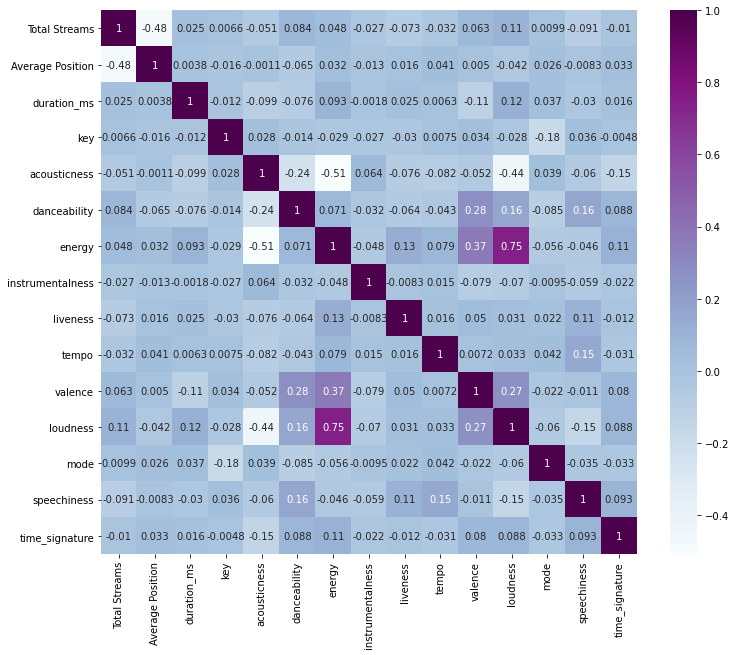

In [1093]:
correlation = df_extended_uniq[heatmap_lst]
# correlation = df_extended[['Position','Streams']]
plt.figure(figsize=(12,10))
sns.heatmap(correlation.corr(), annot=True,cmap="BuPu")
plt.savefig('../FeaturesHeatMap.png', dpi = 100)

In [1094]:
correlation.corr()

Total Streams  Average Position  duration_ms       key  \
Total Streams          1.000000         -0.482015     0.024644  0.006620   
Average Position      -0.482015          1.000000     0.003804 -0.016060   
duration_ms            0.024644          0.003804     1.000000 -0.011596   
key                    0.006620         -0.016060    -0.011596  1.000000   
acousticness          -0.051268         -0.001053    -0.099203  0.028002   
danceability           0.084448         -0.064658    -0.076395 -0.013762   
energy                 0.047828          0.032076     0.092878 -0.028564   
instrumentalness      -0.027246         -0.012929    -0.001828 -0.027228   
liveness              -0.073489          0.015807     0.025000 -0.030322   
tempo                 -0.031806          0.040845     0.006321  0.007451   
valence                0.063445          0.004992    -0.114830  0.033670   
loudness               0.109197         -0.041831     0.120857 -0.028406   
mode                   0.009868          0.026296     0.036772 -0.180954   
speechiness           -0.091134         -0.008252    -0.030416  0.036380   
time_signature        -0.010237          0.033380     0.016426 -0.004829   

                  acousticness  danceability    energy  instrumentalness  \
Total Streams        -0.051268      0.084448  0.047828         -0.027246   
Average Position     -0.001053     -0.064658  0.032076         -0.012929   
duration_ms          -0.099203     -0.076395  0.092878         -0.001828   
key                   0.028002     -0.013762 -0.028564         -0.027228   
acousticness          1.000000     -0.235713 -0.508201          0.063545   
danceability         -0.235713      1.000000  0.070874         -0.031916   
energy               -0.508201      0.070874  1.000000         -0.047616   
instrumentalness      0.063545     -0.031916 -0.047616          1.000000   
liveness             -0.075998     -0.064066  0.129998         -0.008336   
tempo                -0.081775     -0.042665  0.079041          0.015285   
valence              -0.051884      0.280088  0.365995         -0.079022   
loudness             -0.442122      0.163476  0.745531         -0.070353   
mode                  0.038833     -0.084658 -0.055686         -0.009520   
speechiness          -0.059782      0.163955 -0.046156         -0.058780   
time_signature       -0.145216      0.088484  0.113958         -0.021686   

                  liveness     tempo   valence  loudness      mode  \
Total Streams    -0.073489 -0.031806  0.063445  0.109197  0.009868   
Average Position  0.015807  0.040845  0.004992 -0.041831  0.026296   
duration_ms       0.025000  0.006321 -0.114830  0.120857  0.036772   
key              -0.030322  0.007451  0.033670 -0.028406 -0.180954   
acousticness     -0.075998 -0.081775 -0.051884 -0.442122  0.038833   
danceability     -0.064066 -0.042665  0.280088  0.163476 -0.084658   
energy            0.129998  0.079041  0.365995  0.745531 -0.055686   
instrumentalness -0.008336  0.015285 -0.079022 -0.070353 -0.009520   
liveness          1.000000  0.016420  0.050201  0.030773  0.021736   
tempo             0.016420  1.000000  0.007210  0.033265  0.041551   
valence           0.050201  0.007210  1.000000  0.271801 -0.022484   
loudness          0.030773  0.033265  0.271801  1.000000 -0.060128   
mode              0.021736  0.041551 -0.022484 -0.060128  1.000000   
speechiness       0.105940  0.152758 -0.010539 -0.151725 -0.034681   
time_signature   -0.011543 -0.030754  0.080103  0.087949 -0.032740   

                  speechiness  time_signature  
Total Streams       -0.091134       -0.010237  
Average Position    -0.008252        0.033380  
duration_ms         -0.030416        0.016426  
key                  0.036380       -0.004829  
acousticness        -0.059782       -0.145216  
danceability         0.163955        0.088484  
energy              -0.046156        0.113958  
instrumentalness    -0.058780       -0.021686  
liveness             0.105940  

### Beta Version of Logistic Regression

In [1409]:
def split_sample_combine(df, cutoff=50, col='popularity score', rand=None):
    # split out popular rows above the popularity cutoff
    split_pop_df = df[df[col] > cutoff].copy()
    
    # get the leftover rows, the 'unpopular' songs
    df_leftover = df[df[col] < cutoff].copy()
    
    # what % of the original data do we now have?
    ratio = split_pop_df.shape[0] / df.shape[0]
    
    # what % of leftover rows do we need?
    ratio_leftover = split_pop_df.shape[0] / df_leftover.shape[0]
    
    # get the exact # of unpopular rows needed, using a random sampler
    unpop_df_leftover, unpop_df_to_add = train_test_split(df_leftover, \
                                                          test_size=ratio_leftover, \
                                                          random_state = rand)
    
    # combine the dataframes to get total rows = split_pop_df * 2
    # ssc stands for "split_sample_combine"
    ssc_df = split_pop_df.append(unpop_df_to_add).reset_index(drop=True)

    # shuffle the df
    ssc_df = ssc_df.sample(frac=1, random_state=rand).reset_index(drop=True)
    
    # add key_notes mapping key num vals to notes
    key_mapping = {0.0: 'C', 1.0: 'C♯,D♭', 2.0: 'D', 3.0: 'D♯,E♭', 
                   4.0: 'E', 5.0: 'F', 6.0: 'F♯,G♭', 7.0: 'G', 
                   8.0: 'G♯,A♭', 9.0: 'A', 10.0: 'A♯,B♭', 11.0: 'B'}
    ssc_df['key_notes'] = ssc_df['key'].map(key_mapping)
    
    # add columns relating to popularity
    ssc_df['pop_frac'] = ssc_df['popularity score'] / 100
    ssc_df['pop_cat'] = np.where(ssc_df['popularity score'] > cutoff, "Popular", "Not_Popular")
    ssc_df['pop_bin'] = np.where(ssc_df['popularity score'] > cutoff, 1, 0)
    
    return ssc_df

def return_X_y_logistic(df):
    df = df.copy()

    # define columns to use for each
    X_cols = ['acousticness', 'danceability', 'duration_ms', 'energy', 
              'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 
              'speechiness', 'tempo', 'time_signature','valence']

    # use 1's and 0's for logistic
    y_col = ['pop_bin']

    # split into X and y
    X = df[X_cols]
    y = df[y_col]

    return X, y

def return_X_y_logistic_more_cols(df):
    df = df.copy()

    # define columns to use for each
    X_cols = ['acousticness', 'danceability', 'duration_ms', 'energy', 
              'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 
              'speechiness', 'tempo', 'time_signature', 'valence']

    # use 1's and 0's for logistic
    y_col = ['pop_bin']

    # split into X and y
    X = df[X_cols]
    y = df[y_col]

    return X, y

def return_X_y_logistic_sig_only(df):
    df = df.copy()

    # define columns to use for each
    X_cols = ['danceability','energy', 
              'instrumentalness', 'loudness']

    # use 1's and 0's for logistic
    y_col = ['pop_bin']

    # split into X and y
    X = df[X_cols]
    y = df[y_col]

    return X, y

def standardize_X_sig_only(X):  
    X = X.copy()
    
    cols = ['loudness']
    # standardize only columns not between 0 and 1
    for col in cols:
        new_col_name = col + "_std"
        X[new_col_name] = (X[col] - X[col].mean()) / X[col].std()
        
    X_cols = ['danceability','energy', 
              'instrumentalness', 'loudness_std']

    # return the std columns in a dataframe
    X = X[X_cols]
    
    return X

def standardize_X(X):  
    X = X.copy()
    
    # standardize only columns not between 0 and 1
    for col in cols_to_standardize:
        new_col_name = col + "_std"
        X[new_col_name] = (X[col] - X[col].mean()) / X[col].std()
        
    X_cols = ['acousticness', 'danceability', 'duration_ms_std', 'energy', 
                  'instrumentalness', 'key', 'liveness', 'loudness_std', 'mode', 
                  'speechiness', 'tempo_std', 'time_signature', 'valence']

    # return the std columns in a dataframe
    X = X[X_cols]
    
    return X

def standardize_X_train_test(X_train, X_test):  
    X_train = X_train.copy()
    X_test = X_test.copy() 
    
    # standardize only columns not between 0 and 1
    for col in cols_to_standardize:
        new_col_name = col + "_std"
        X_train[new_col_name] = (X_train[col] - X_train[col].mean()) / X_train[col].std()
        X_test[new_col_name] = (X_test[col] - X_test[col].mean()) / X_test[col].std()
    
    X_cols = ['acousticness', 'danceability', 'duration_ms_std', 'energy', 
                  'instrumentalness', 'key', 'liveness', 'loudness_std', 'mode', 
                  'speechiness', 'tempo_std', 'time_signature', 'valence']

    # return the std columns in a dataframe
    X_train_std = X_train[X_cols]
    X_test_std = X_test[X_cols]
    
    return X_train_std, X_test_std

# Create a basic logistic regression
def basic_logistic_regression(df, cutoff=55, rand=0, sig_only=False):
    df = df.copy()

    if sig_only == True:
        X, y = return_X_y_logistic_sig_only(split_sample_combine(df, cutoff=cutoff, rand=rand))
        X = standardize_X_sig_only(X)

    else:
        X, y = return_X_y_logistic(split_sample_combine(df, cutoff=80, rand=rand))
        X = standardize_X(X)

    X_const = add_constant(X, prepend=True)

    logit_model = Logit(y, X_const).fit()
    
    print(logit_model.summary())

    return logit_model

def logistic_regression_with_kfold(df, cutoff=55, rand=0, sig_only=False):
    df = df.copy()
    
    if sig_only == True:
        X, y = return_X_y_logistic_sig_only(split_sample_combine(df, cutoff=cutoff, rand=rand))
        X = standardize_X_sig_only(X)

    else:
        X, y = return_X_y_logistic(split_sample_combine(df, cutoff=cutoff, rand=rand))
        X = standardize_X(X)

    X = X.values
    y = y.values.ravel()

    classifier = LogisticRegression()

    # before kFold
    y_predict = classifier.fit(X, y).predict(X)
    y_true = y
    accuracy_score(y_true, y_predict)
    print(f"accuracy: {accuracy_score(y_true, y_predict)}")
    print(f"precision: {precision_score(y_true, y_predict)}")
    print(f"recall: {recall_score(y_true, y_predict)}")
    print(f"The coefs are: {classifier.fit(X,y).coef_}")

    # with kfold
    kfold = KFold(len(y))

    accuracies = []
    precisions = []
    recalls = []

    for train_index, test_index in kfold:
        model = LogisticRegression()
        model.fit(X[train_index], y[train_index])

        y_predict = model.predict(X[test_index])
        y_true = y[test_index]

        accuracies.append(accuracy_score(y_true, y_predict))
        precisions.append(precision_score(y_true, y_predict))
        recalls.append(recall_score(y_true, y_predict))

    print(f"accuracy: {np.average(accuracies)}")
    print(f"precision: {np.average(precisions)}")
    print(f"recall: {np.average(recalls)}")
    
def logistic_regression_final(df, plot_the_roc=True, cutoff=80):
    df = df.copy()
    
    X, y = return_X_y_logistic_more_cols(split_sample_combine(df, cutoff=cutoff, rand=2))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

    global df_train_results_log80 
    global df_test_results_log80
    df_train_results_log80 = X_train.join(y_train)
    df_test_results_log80 = X_test.join(y_test)

    # standardize X_train and X_test
    X_train = standardize_X(X_train)
    X_test = standardize_X(X_test)

    X_train = X_train.values
    y_train = y_train.values.ravel()

    X_test = X_test.values
    y_test = y_test.values.ravel()

    global sanity_check
    sanity_check = X_test

    ## Run logistic regression on all the data
    classifier = LogisticRegression()
    # note using .predict_proba() below, which is the probability of each class
    
    #predict values for X_train
    y_predict_train = classifier.fit(X_train,y_train).predict(X_train)
    probs_0and1_train = classifier.fit(X_train,y_train).predict_proba(X_train)
    y_prob_P_train = probs_0and1_train[:,1]

    # predict values for X_test
    y_predict_test = classifier.fit(X_train,y_train).predict(X_test)
    probs_0and1_test = classifier.fit(X_train,y_train).predict_proba(X_test) # yes!
    y_prob_P_test = probs_0and1_test[:,1]

    # calculate metrics needed to use for ROC curve below
    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_prob_P_train, pos_label=1)
    auc_train = metrics.roc_auc_score(y_train, y_prob_P_train) # note we are scoring on our training data!

    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_prob_P_test, pos_label=1)
    auc_test = metrics.roc_auc_score(y_test, y_prob_P_test) # note we are scoring on our training data!

    # print some metrics
    print("Train accuracy: {:.3f}".format(accuracy_score(y_train, y_predict_train)))
    print("Test accuracy: {:.3f}".format(accuracy_score(y_test, y_predict_test)))

    print("Train recall: {:.3f}".format(recall_score(y_train, y_predict_train)))
    print("Test recall: {:.3f}".format(recall_score(y_test, y_predict_test)))

    print("Train precision: {:.3f}".format(precision_score(y_train, y_predict_train)))
    print("Test precision: {:.3f}".format(precision_score(y_test, y_predict_test)))

    print("Train auc: {:.3f}".format(auc_train))
    print("Test auc: {:.3f}".format(auc_test))

    global conf_matrix_log80_train
    global conf_matrix_log80_test
    conf_matrix_log80_train = confusion_matrix(y_train, y_predict_train)
    conf_matrix_log80_test = confusion_matrix(y_test, y_predict_test)

    global final_coefs
    global final_intercept
    final_coefs = classifier.fit(X_train,y_train).coef_
    final_intercept = classifier.fit(X_train,y_train).intercept_

    # Back of the envelope calcs to make sure metrics above are correct
    df_train_results_log80 = df_train_results_log80.reset_index(drop=True)
    df_train_results_log80['pop_predict'] = y_prob_P_train

    df_test_results_log80 = df_test_results_log80.reset_index(drop=True)
    df_test_results_log80['pop_predict'] = y_prob_P_test

    df_train_results_log80['pop_predict_bin'] = np.where(df_train_results_log80['pop_predict'] >= 0.5, 1, 0)
    df_test_results_log80['pop_predict_bin'] = np.where(df_test_results_log80['pop_predict'] >= 0.5, 1, 0)
    
#     print("Back of the envelope calc for Train Recall")
#     print(sum((df_train_results_log80['pop_predict_bin'].values * df_train_results_log80['pop_bin'].values))/ df_train_results_log80['pop_bin'].sum())

    if plot_the_roc == True:
        # Plot the ROC
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
                label='Random Classifier')
        ax.plot(fpr_train, tpr_train, color='dodgerblue', lw=2, label='Model Train')
        ax.plot(fpr_test, tpr_test, color='tomato', lw=2, label='Model Test')
        ax.set_xlabel("False Positive Rate", fontsize=20)
        ax.set_ylabel("True Positive Rate", fontsize=20)
        ax.yaxis.set_tick_params(labelsize=20)
        ax.xaxis.set_tick_params(labelsize=20)
        ax.set_title("ROC curve - Cutoff: " + str(cutoff), fontsize=24)
        ax.text(0.05, 0.65, " ".join(["AUC train:",str(auc_train.round(3))]), color='dodgerblue', fontsize=20)
        ax.text(0.65, 0.6, " ".join(["AUC test:",str(auc_test.round(3))]), color='tomato', fontsize=20)
        ax.legend(fontsize=24, loc='lower right')
        plt.savefig('../ROC_Curve.png', dpi = 100)
        plt.show()
        
# print out confusion matrix
def print_confusion_matrix(df, cutoff, rand=0):
    df = df.copy()

    X, y = return_X_y_logistic(split_sample_combine(df, cutoff=80, rand=rand))
    X = standardize_X(X)

    X = X.values
    y = y.values.ravel()

    ## Run logistic regression on all the data
    classifier = LogisticRegression()
    # note using .predict() below, which uses default 0.5 for a binary classifier
    y_pred = classifier.fit(X,y).predict(X) # agh! this uses 0.5 threshold for binary classifier
    y_true = y

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    print("| TN | FP |\n| FN | TP |\n")
    print(cnf_matrix)
    print(f"The accurracy is {accuracy_score(y_true, y_pred)}")
    print(f"The accurracy (check) is {(cnf_matrix[1][1]+ cnf_matrix[0][0])/np.sum(cnf_matrix)}")
    
# plot popularity score cutoffs vs. logistic regression metrics
def plot_cutoffs_vs_metrics_test(df):
    df = df.copy()

    df_cols = ['auc', 'accuracy', 'precision', 'recall', 'cutoff', 'type']
    df_metrics = pd.DataFrame(columns = df_cols)
    cutoff_range = [55, 60, 65, 70, 75, 80, 85, 90, 95]
    
    for cutoff in cutoff_range:
        X, y = return_X_y_logistic(split_sample_combine(df, cutoff=cutoff, rand=0))

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

        X_train = standardize_X(X_train)
        X_test = standardize_X(X_test)

        X_train = X_train.values
        y_train = y_train.values.ravel()

        X_test = X_test.values
        y_test = y_test.values.ravel()
        
        classifier = LogisticRegression()
        y_predict_train = classifier.fit(X_train, y_train).predict(X_train)
        probs_0and1_train = classifier.fit(X_train,y_train).predict_proba(X_train)
        y_prob_P_train = probs_0and1_train[:,1]
        
        y_predict_test = classifier.fit(X_test, y_test).predict(X_test)
        probs_0and1_train = classifier.fit(X_test,y_test).predict_proba(X_test)
        y_prob_P_test = probs_0and1_train[:,1]
        
        test_metrics = []
        ## calculate metrics for JUST train
#         test_metrics.append(metrics.roc_auc_score(y_train, y_prob_P_train))
#         test_metrics.append(accuracy_score(y_train, y_predict_train))
#         test_metrics.append(precision_score(y_train, y_predict_train))
#         test_metrics.append(recall_score(y_train, y_predict_train))
#         test_metrics.append(int(cutoff))
#         test_metrics.append("Test")
        
        ## calculate metrics for JUST train
        test_metrics.append(metrics.roc_auc_score(y_test, y_prob_P_test))
        test_metrics.append(accuracy_score(y_test, y_predict_test))
        test_metrics.append(precision_score(y_test, y_predict_test))
        test_metrics.append(recall_score(y_test, y_predict_test))
        test_metrics.append(int(cutoff))
        test_metrics.append("Test")
        
        df_metrics.loc[cutoff] = test_metrics
        df_metrics = df_metrics.reset_index(drop=True)
        df_metrics["cutoff"] = pd.to_numeric(df_metrics["cutoff"])
        
    # plot metrics vs. popularity score cutoff
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)

    ax.plot(df_metrics['cutoff'], df_metrics['auc'], color='b', lw=2, label='auc')
    ax.plot(df_metrics['cutoff'], df_metrics['accuracy'], color='r', lw=2, label='accuracy')
    ax.plot(df_metrics['cutoff'], df_metrics['precision'], color='g', lw=2, label='precision')
    ax.plot(df_metrics['cutoff'], df_metrics['recall'], color='y', lw=2, label='recall')

    ax.set_xlabel("Popularity Score Cutoff", fontsize=20)
    ax.set_ylabel("Area (auc) / Rate (others)", fontsize=20)
    ax.set_title("Metrics vs Popularity Score Cutoff Values - Testing Dataset:", fontsize=24)
    ax.legend(fontsize=24)
    plt.show()

def plot_cutoffs_vs_metrics_train(df):
    df = df.copy()

    df_cols = ['auc', 'accuracy', 'precision', 'recall', 'cutoff', 'type']
    df_metrics = pd.DataFrame(columns = df_cols)
    cutoff_range = [55, 60, 65, 70, 75, 80, 85, 90, 95]
    
    for cutoff in cutoff_range:
        X, y = return_X_y_logistic(split_sample_combine(df, cutoff=cutoff, rand=0))

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

        X_train = standardize_X(X_train)
        X_test = standardize_X(X_test)

        X_train = X_train.values
        y_train = y_train.values.ravel()

        X_test = X_test.values
        y_test = y_test.values.ravel()
        
        classifier = LogisticRegression()
        y_predict_train = classifier.fit(X_train, y_train).predict(X_train)
        probs_0and1_train = classifier.fit(X_train,y_train).predict_proba(X_train)
        y_prob_P_train = probs_0and1_train[:,1]
        
        y_predict_test = classifier.fit(X_test, y_test).predict(X_test)
        probs_0and1_train = classifier.fit(X_test,y_test).predict_proba(X_test)
        y_prob_P_test = probs_0and1_train[:,1]
        
        test_metrics = []
        ## calculate metrics for JUST train
        test_metrics.append(metrics.roc_auc_score(y_train, y_prob_P_train))
        test_metrics.append(accuracy_score(y_train, y_predict_train))
        test_metrics.append(precision_score(y_train, y_predict_train))
        test_metrics.append(recall_score(y_train, y_predict_train))
        test_metrics.append(int(cutoff))
        test_metrics.append("Test")
        
        ## calculate metrics for JUST train
#         test_metrics.append(metrics.roc_auc_score(y_test, y_prob_P_test))
#         test_metrics.append(accuracy_score(y_test, y_predict_test))
#         test_metrics.append(precision_score(y_test, y_predict_test))
#         test_metrics.append(recall_score(y_test, y_predict_test))
#         test_metrics.append(int(cutoff))
#         test_metrics.append("Test")
        
        df_metrics.loc[cutoff] = test_metrics
        df_metrics = df_metrics.reset_index(drop=True)
        df_metrics["cutoff"] = pd.to_numeric(df_metrics["cutoff"])
        
    # plot metrics vs. popularity score cutoff
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)

    ax.plot(df_metrics['cutoff'], df_metrics['auc'], color='deepskyblue', marker='o', lw=2, label='auc')
    ax.plot(df_metrics['cutoff'], df_metrics['accuracy'], color='firebrick', lw=2, marker='P', label='accuracy')
    ax.plot(df_metrics['cutoff'], df_metrics['precision'], color='forestgreen', marker='v', lw=2, label='precision')
    ax.plot(df_metrics['cutoff'], df_metrics['recall'], color='orange', lw=2, marker='X', label='recall')

    ax.set_xlabel("Popularity Score Cutoff", fontsize=20)
    ax.set_ylabel("Area (auc) / Rate (others)", fontsize=20)
    ax.set_title("Metrics vs Popularity Score Cutoff Values - Training Dataset:", fontsize=24)
    ax.legend(fontsize=15, loc='upper left')
    ax.yaxis.set_tick_params(labelsize=15)
    ax.xaxis.set_tick_params(labelsize=15)
    plt.grid()
    plt.savefig('../metric_vs_cutoff.png', dpi = 100)
    plt.show()

# plot a confusion matrix
def plot_confusion_matrix(cm, ax, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlGn):
    """
    This function prints and plots the confusion matrix.
    """
    font_size = 35
    p = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0)
    ax.set_title(title,fontsize=font_size)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, fontsize=30)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, rotation=90, va='center', fontsize=30)
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if i == 1 and j == 1:
            lbl = "(True Positive)"
        elif i == 0 and j == 0:
            lbl = "(True Negative)"
        elif i == 1 and j == 0:
            lbl = "(False Negative)"
        elif i == 0 and j == 1:
            lbl = "(False Positive)"
        ax.text(j, i, "{:0.3f} \n{}".format(cm[i, j], lbl),
                 horizontalalignment="center", size = font_size,
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    ax.set_ylabel('Actual',fontsize=font_size)
    ax.set_xlabel('Predicted',fontsize=font_size)
    
def plot_conf_matrix_Train_Test():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.grid(False)
    class_names = ["Not Popular","Popular"]
    plot_confusion_matrix(conf_matrix_log80_train, ax1, classes=class_names,normalize=True,
                      title='Confusion Matrix(Train), threshold = 0.5')

    ax2.grid(False)
    class_names = ["Not Popular","Popular"]
    plot_confusion_matrix(conf_matrix_log80_test, ax2, classes=class_names,normalize=True,
                      title='Confusion Matrix(Test), threshold = 0.5')


In [1361]:
def logistic_regression_final_data(df, cutoff=80):
    df = df.copy()
    
    X, y = return_X_y_logistic_more_cols(split_sample_combine(df, cutoff=cutoff, rand=2))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

    global df_train_results_log80 
    global df_test_results_log80
    df_train_results_log80 = X_train.join(y_train)
    df_test_results_log80 = X_test.join(y_test)

    # standardize X_train and X_test
    X_train = standardize_X(X_train)
    X_test = standardize_X(X_test)

    X_train = X_train.values
    y_train = y_train.values.ravel()

    X_test = X_test.values
    y_test = y_test.values.ravel()

    global sanity_check
    sanity_check = X_test

    ## Run logistic regression on all the data
    classifier = LogisticRegression()
    # note using .predict_proba() below, which is the probability of each class
    
    #predict values for X_train
    y_predict_train = classifier.fit(X_train,y_train).predict(X_train)
    probs_0and1_train = classifier.fit(X_train,y_train).predict_proba(X_train)
    y_prob_P_train = probs_0and1_train[:,1]

    # predict values for X_test
    y_predict_test = classifier.fit(X_train,y_train).predict(X_test)
    probs_0and1_test = classifier.fit(X_train,y_train).predict_proba(X_test) # yes!
    y_prob_P_test = probs_0and1_test[:,1]

    # calculate metrics needed to use for ROC curve below
    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_prob_P_train, pos_label=1)
    auc_train = metrics.roc_auc_score(y_train, y_prob_P_train) # note we are scoring on our training data!

    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_prob_P_test, pos_label=1)
    auc_test = metrics.roc_auc_score(y_test, y_prob_P_test) # note we are scoring on our training data!

    # print some metrics
    print("Train accuracy: {:.3f}".format(accuracy_score(y_train, y_predict_train)))
    print("Test accuracy: {:.3f}".format(accuracy_score(y_test, y_predict_test)))

    print("Train recall: {:.3f}".format(recall_score(y_train, y_predict_train)))
    print("Test recall: {:.3f}".format(recall_score(y_test, y_predict_test)))

    print("Train precision: {:.3f}".format(precision_score(y_train, y_predict_train)))
    print("Test precision: {:.3f}".format(precision_score(y_test, y_predict_test)))

    print("Train auc: {:.3f}".format(auc_train))
    print("Test auc: {:.3f}".format(auc_test))

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

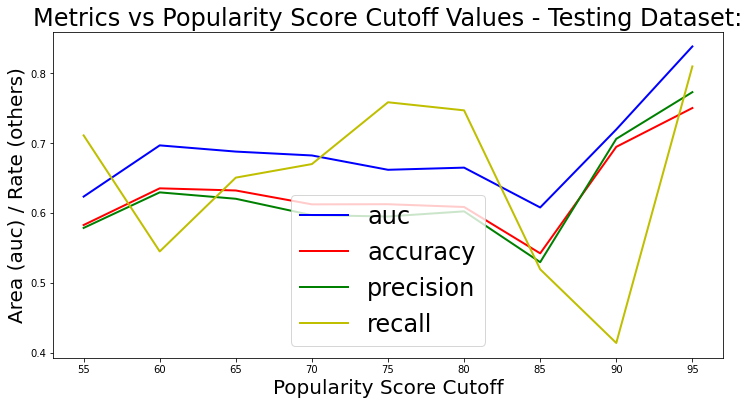

In [1387]:
plot_cutoffs_vs_metrics_test(df_extended_uniq)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

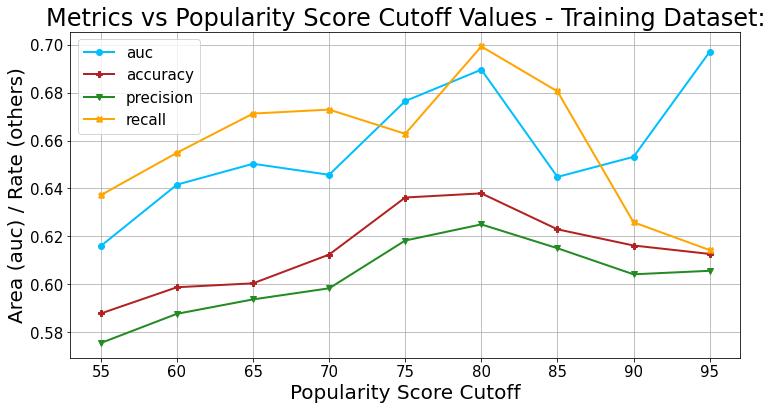

In [1416]:
plot_cutoffs_vs_metrics_train(df_extended_uniq)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Train accuracy: 0.605
Test accuracy: 0.579
Train recall: 0.632
Test recall: 0.638
Train precision: 0.594
Test precision: 0.594
Train auc: 0.657
Test auc: 0.589


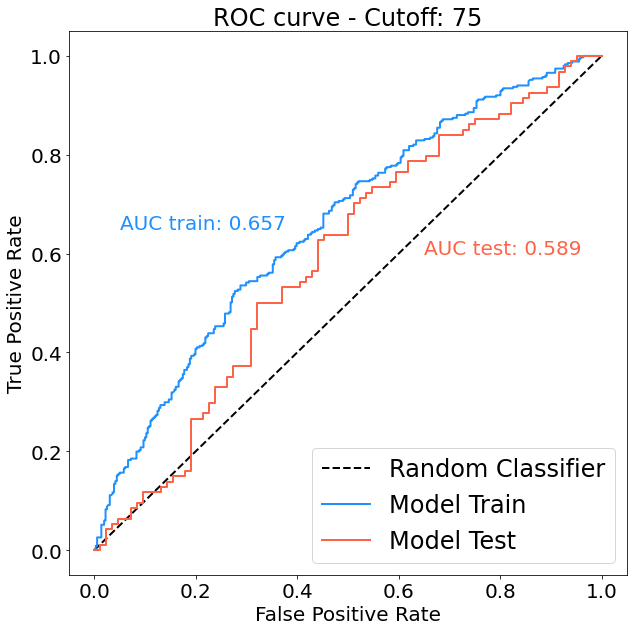

In [1352]:
logistic_regression_final(df_extended_uniq, plot_the_roc=True, cutoff=75)

Normalized confusion matrix
[[0.51190476 0.48809524]
 [0.36170213 0.63829787]]


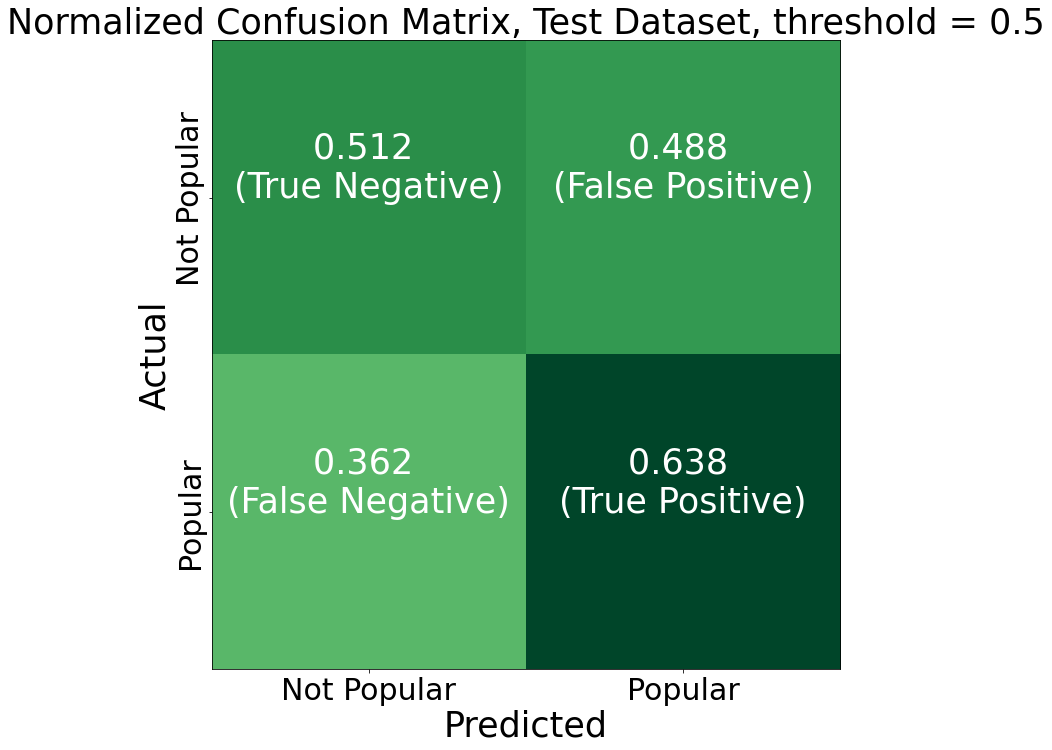

In [1354]:
plot_conf_matrix_Test()

Normalized confusion matrix
[[0.57894737 0.42105263]
 [0.36752137 0.63247863]]


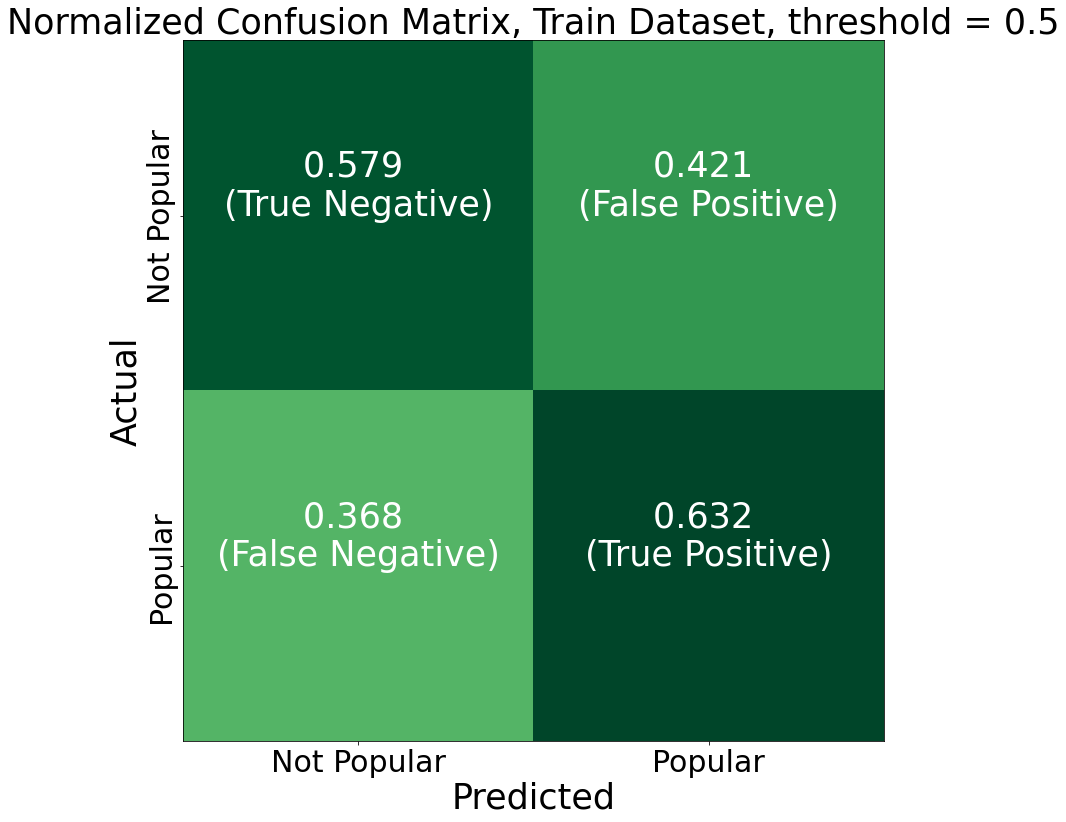

In [1355]:
plot_conf_matrix_Train()

### Alpha Version

In [1246]:
def split_sample_combine(df, cutoff=50, col='popularity score', rand=None):
    # split out popular rows above the popularity cutoff
    split_pop_df = df[df[col] > cutoff].copy()
    
    # get the leftover rows, the 'unpopular' songs
    df_leftover = df[df[col] <= cutoff].copy()
    
    # what % of the original data do we now have?
    ratio = split_pop_df.shape[0] / df.shape[0]
    
    # what % of leftover rows do we need?
    ratio_leftover = split_pop_df.shape[0] / df_leftover.shape[0]
    
    # get the exact # of unpopular rows needed, using a random sampler
    unpop_df_leftover, unpop_df_to_add = train_test_split(df_leftover, \
                                                          test_size=ratio_leftover, \
                                                          random_state = rand)
    
    # combine the dataframes to get total rows = split_pop_df * 2
    # ssc stands for "split_sample_combine"
    ssc_df = split_pop_df.append(unpop_df_to_add).reset_index(drop=True)

    # shuffle the df
    ssc_df = ssc_df.sample(frac=1, random_state=rand).reset_index(drop=True)
    
    # add key_notes mapping key num vals to notes
    key_mapping = {0.0: 'C', 1.0: 'C♯,D♭', 2.0: 'D', 3.0: 'D♯,E♭', 
                   4.0: 'E', 5.0: 'F', 6.0: 'F♯,G♭', 7.0: 'G', 
                   8.0: 'G♯,A♭', 9.0: 'A', 10.0: 'A♯,B♭', 11.0: 'B'}
    ssc_df['key_notes'] = ssc_df['key'].map(key_mapping)
    
    # add columns relating to popularity
    ssc_df['pop_frac'] = ssc_df['popularity score'] / 100
    ssc_df['pop_cat'] = np.where(ssc_df['popularity score'] > cutoff, "Popular", "Not_Popular")
    ssc_df['pop_bin'] = np.where(ssc_df['popularity score'] > cutoff, 1, 0)
    
    return ssc_df

In [1247]:
def return_X_y_logistic(df):
    df = df.copy()

    # define columns to use for each
    X_cols = ['acousticness', 'danceability', 'duration_ms', 'energy', 
              'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 
              'speechiness', 'tempo', 'valence']

    # use 1's and 0's for logistic
    y_col = ['pop_bin']

    # split into X and y
    X = df[X_cols]
    y = df[y_col]

    return X, y

In [1248]:
def return_X_y_logistic_more_cols(df):
    df = df.copy()

    # define columns to use for each
    X_cols = ['acousticness', 'danceability', 'duration_ms', 'energy', 
              'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 
              'speechiness', 'tempo', 'time_signature', 'valence']

    # use 1's and 0's for logistic
    y_col = ['pop_bin']

    # split into X and y
    X = df[X_cols]
    y = df[y_col]

    return X, y


In [1249]:
def return_X_y_logistic_sig_only(df):
    df = df.copy()

    # define columns to use for each
    X_cols = ['danceability','energy', 
              'instrumentalness', 'loudness']

    # use 1's and 0's for logistic
    y_col = ['pop_bin']

    # split into X and y
    X = df[X_cols]
    y = df[y_col]

    return X, y

In [1250]:
def standardize_X_sig_only(X):  
    X = X.copy()
    
    cols = ['loudness']
    # standardize only columns not between 0 and 1
    for col in cols:
        new_col_name = col + "_std"
        X[new_col_name] = (X[col] - X[col].mean()) / X[col].std()
        
    X_cols = ['danceability','energy', 
              'instrumentalness', 'loudness_std']

    # return the std columns in a dataframe
    X = X[X_cols]
    
    return X


In [1251]:
def standardize_X(X):  
    X = X.copy()
    
    # standardize only columns not between 0 and 1
    for col in cols_to_standardize:
        new_col_name = col + "_std"
        X[new_col_name] = (X[col] - X[col].mean()) / X[col].std()
        
    X_cols = ['acousticness', 'danceability', 'duration_ms_std', 'energy', 
                  'instrumentalness', 'key', 'liveness', 'loudness_std', 'mode', 
                  'speechiness', 'tempo_std', 'time_signature', 'valence']

    # return the std columns in a dataframe
    X = X[X_cols]
    
    return X


In [1252]:
def standardize_X_train_test(X_train, X_test):  
    X_train = X_train.copy()
    X_test = X_test.copy() 
    
    # standardize only columns not between 0 and 1
    for col in cols_to_standardize:
        new_col_name = col + "_std"
        X_train[new_col_name] = (X_train[col] - X_train[col].mean()) / X_train[col].std()
        X_test[new_col_name] = (X_test[col] - X_test[col].mean()) / X_test[col].std()
    
    X_cols = ['acousticness', 'danceability', 'duration_ms_std', 'energy', 
                  'instrumentalness', 'key', 'liveness', 'loudness_std', 'mode', 
                  'speechiness', 'tempo_std', 'time_signature', 'valence']

    # return the std columns in a dataframe
    X_train_std = X_train[X_cols]
    X_test_std = X_test[X_cols]
    
    return X_train_std, X_test_std

In [1253]:
# Create a basic logistic regression
def basic_logistic_regression(df, cutoff=55, rand=0, sig_only=False):
    df = df.copy()

    if sig_only == True:
        X, y = return_X_y_logistic_sig_only(split_sample_combine(df, cutoff=cutoff, rand=rand))
        X = standardize_X_sig_only(X)

    else:
        X, y = return_X_y_logistic(split_sample_combine(df, cutoff=80, rand=rand))
        X = standardize_X(X)

    X_const = add_constant(X, prepend=True)

    logit_model = Logit(y, X_const).fit()
    
    print(logit_model.summary())

    return logit_model

In [1254]:
def logistic_regression_with_kfold(df, cutoff=55, rand=0, sig_only=False):
    df = df.copy()
    
    if sig_only == True:
        X, y = return_X_y_logistic_sig_only(split_sample_combine(df, cutoff=cutoff, rand=rand))
        X = standardize_X_sig_only(X)

    else:
        X, y = return_X_y_logistic(split_sample_combine(df, cutoff=cutoff, rand=rand))
        X = standardize_X(X)

    X = X.values
    y = y.values.ravel()

    classifier = LogisticRegression()

    # before kFold
    y_predict = classifier.fit(X, y).predict(X)
    y_true = y
    accuracy_score(y_true, y_predict)
    print(f"accuracy: {accuracy_score(y_true, y_predict)}")
    print(f"precision: {precision_score(y_true, y_predict)}")
    print(f"recall: {recall_score(y_true, y_predict)}")
    print(f"The coefs are: {classifier.fit(X,y).coef_}")

    # with kfold
    kfold = KFold(len(y))

    accuracies = []
    precisions = []
    recalls = []

    for train_index, test_index in kfold:
        model = LogisticRegression()
        model.fit(X[train_index], y[train_index])

        y_predict = model.predict(X[test_index])
        y_true = y[test_index]

        accuracies.append(accuracy_score(y_true, y_predict))
        precisions.append(precision_score(y_true, y_predict))
        recalls.append(recall_score(y_true, y_predict))

    print(f"accuracy: {np.average(accuracies)}")
    print(f"precision: {np.average(precisions)}")
    print(f"recall: {np.average(recalls)}")

In [1339]:
def logistic_regression_final(df, plot_the_roc=True, cutoff = 80):
    df = df.copy()
    
    X, y = return_X_y_logistic_more_cols(split_sample_combine(df, cutoff=cutoff, rand=2))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

    global df_train_results_log80 
    global df_test_results_log80
    df_train_results_log80 = X_train.join(y_train)
    df_test_results_log80 = X_test.join(y_test)

    # standardize X_train and X_test
    X_train = standardize_X(X_train)
    X_test = standardize_X(X_test)

    X_train = X_train.values
    y_train = y_train.values.ravel()

    X_test = X_test.values
    y_test = y_test.values.ravel()

    global sanity_check
    sanity_check = X_test

    ## Run logistic regression on all the data
    classifier = LogisticRegression()
    # note using .predict_proba() below, which is the probability of each class
    
    #predict values for X_train
    y_predict_train = classifier.fit(X_train,y_train).predict(X_train)
    probs_0and1_train = classifier.fit(X_train,y_train).predict_proba(X_train)
    y_prob_P_train = probs_0and1_train[:,1]

    # predict values for X_test
    y_predict_test = classifier.fit(X_train,y_train).predict(X_test)
    probs_0and1_test = classifier.fit(X_train,y_train).predict_proba(X_test) # yes!
    y_prob_P_test = probs_0and1_test[:,1]

    # calculate metrics needed to use for ROC curve below
    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_prob_P_train, pos_label=1)
    auc_train = metrics.roc_auc_score(y_train, y_prob_P_train) # note we are scoring on our training data!

    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_prob_P_test, pos_label=1)
    auc_test = metrics.roc_auc_score(y_test, y_prob_P_test) # note we are scoring on our training data!

    # print some metrics
    print("Train accuracy: {:.2f}".format(accuracy_score(y_train, y_predict_train)))
    print("Test accuracy: {:.2f}".format(accuracy_score(y_test, y_predict_test)))

    print("Train recall: {:.2f}".format(recall_score(y_train, y_predict_train)))
    print("Test recall: {:.2f}".format(recall_score(y_test, y_predict_test)))

    print("Train precision: {:.2f}".format(precision_score(y_train, y_predict_train)))
    print("Test precision: {:.2f}".format(precision_score(y_test, y_predict_test)))

    print("Train auc: {:.2f}".format(auc_train))
    print("Test auc: {:.2f}".format(auc_test))

    global conf_matrix_log80_train
    global conf_matrix_log80_test
    conf_matrix_log80_train = confusion_matrix(y_train, y_predict_train)
    conf_matrix_log80_test = confusion_matrix(y_test, y_predict_test)

    global final_coefs
    global final_intercept
    final_coefs = classifier.fit(X_train,y_train).coef_
    final_intercept = classifier.fit(X_train,y_train).intercept_

    # Back of the envelope calcs to make sure metrics above are correct
    df_train_results_log80 = df_train_results_log80.reset_index(drop=True)
    df_train_results_log80['pop_predict'] = y_prob_P_train

    df_test_results_log80 = df_test_results_log80.reset_index(drop=True)
    df_test_results_log80['pop_predict'] = y_prob_P_test

    df_train_results_log80['pop_predict_bin'] = np.where(df_train_results_log80['pop_predict'] >= 0.5, 1, 0)
    df_test_results_log80['pop_predict_bin'] = np.where(df_test_results_log80['pop_predict'] >= 0.5, 1, 0)
    
#     print("Back of the envelope calc for Train Recall")
#     print(sum((df_train_results_log80['pop_predict_bin'].values * df_train_results_log80['pop_bin'].values))/ df_train_results_log80['pop_bin'].sum())

    if plot_the_roc == True:
        # Plot the ROC
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
                label='Random Classifier')
        ax.plot(fpr_train, tpr_train, color='dodgerblue', lw=2, label='Model Train')
        ax.plot(fpr_test, tpr_test, color='tomato', lw=2, label='Model Test')
        ax.set_xlabel("False Positive Rate", fontsize=20)
        ax.set_ylabel("True Positive Rate", fontsize=20)
        ax.yaxis.set_tick_params(labelsize=20)
        ax.xaxis.set_tick_params(labelsize=20)
        ax.set_title("ROC curve - Cutoff: " + str(cutoff), fontsize=24)
        ax.text(0.05, 0.65, " ".join(["AUC train:",str(auc_train.round(3))]), color='dodgerblue', fontsize=20)
        ax.text(0.65, 0.6, " ".join(["AUC test:",str(auc_test.round(3))]), color='tomato', fontsize=20)
        ax.legend(fontsize=24, loc='lower right')
        plt.savefig('../ROC_Curve.png', dpi = 100)
        plt.show()
        
logistic_regression_final(df_extended_uniq, plot_the_roc=True, cutoff=50)

ValueError: test_size=1.0 should be either positive and smaller than the number of samples 890 or a float in the (0, 1) range

In [1257]:
logistic_regression_with_kfold(df, cutoff=80, rand=0)
logistic_regression_with_kfold(df, cutoff=80, rand=0, sig_only=True)

KeyError: 'popularity score'

In [978]:
# print out confusion matrix
def print_confusion_matrix(df, cutoff=55, rand=0):
    df = df.copy()

    X, y = return_X_y_logistic(split_sample_combine(df, cutoff=80, rand=rand))
    X = standardize_X(X)

    X = X.values
    y = y.values.ravel()

    ## Run logistic regression on all the data
    classifier = LogisticRegression()
    # note using .predict() below, which uses default 0.5 for a binary classifier
    y_pred = classifier.fit(X,y).predict(X) # agh! this uses 0.5 threshold for binary classifier
    y_true = y

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    print("| TN | FP |\n| FN | TP |\n")
    print(cnf_matrix)
    print(f"The accurracy is {accuracy_score(y_true, y_pred)}")
    print(f"The accurracy (check) is {(cnf_matrix[1][1]+ cnf_matrix[0][0])/np.sum(cnf_matrix)}")

In [1256]:
# plot popularity score cutoffs vs. logistic regression metrics
def plot_cutoffs_vs_metrics(df):
    df = df.copy()

    df_cols = ['auc', 'accuracy', 'precision', 'recall', 'cutoff', 'type']
    df_metrics = pd.DataFrame(columns = df_cols)
    cutoff_range = [45, 55, 60, 65, 70, 75, 80, 85, 90]
    
    for cutoff in cutoff_range:
        X, y = return_X_y_logistic(split_sample_combine(df, cutoff=cutoff, rand=0))

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

        X_train = standardize_X(X_train)
        X_test = standardize_X(X_test)

        X_train = X_train.values
        y_train = y_train.values.ravel()

        X_test = X_test.values
        y_test = y_test.values.ravel()
        
        classifier = LogisticRegression()
        y_predict_train = classifier.fit(X_train, y_train).predict(X_train)
        probs_0and1_train = classifier.fit(X_train,y_train).predict_proba(X_train)
        y_prob_P_train = probs_0and1_train[:,1]
        
        test_metrics = []
        # calculate metrics for JUST train
        test_metrics.append(metrics.roc_auc_score(y_train, y_prob_P_train))
        test_metrics.append(accuracy_score(y_train, y_predict_train))
        test_metrics.append(precision_score(y_train, y_predict_train))
        test_metrics.append(recall_score(y_train, y_predict_train))
        test_metrics.append(int(cutoff))
        test_metrics.append("Test")
        
        df_metrics.loc[cutoff] = test_metrics
        df_metrics = df_metrics.reset_index(drop=True)
        df_metrics["cutoff"] = pd.to_numeric(df_metrics["cutoff"])
        
    # plot metrics vs. popularity score cutoff
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)

    ax.plot(df_metrics['cutoff'], df_metrics['auc'], color='b', lw=2, label='auc')
    ax.plot(df_metrics['cutoff'], df_metrics['accuracy'], color='r', lw=2, label='accuracy')
    ax.plot(df_metrics['cutoff'], df_metrics['precision'], color='g', lw=2, label='precision')
    ax.plot(df_metrics['cutoff'], df_metrics['recall'], color='y', lw=2, label='recall')

    ax.set_xlabel("Popularity Score Cutoff", fontsize=20)
    ax.set_ylabel("Area (auc) / Rate (others)", fontsize=20)
    ax.set_title("Metrics vs Popularity Score Cutoff Values - Training Dataset:", fontsize=24)
    ax.legend(fontsize=24)
    plt.show()
plot_cutoffs_vs_metrics(df_extended_uniq)

ValueError: test_size=1.1948212083847103 should be either positive and smaller than the number of samples 811 or a float in the (0, 1) range

In [1227]:
# plot a confusion matrix
def plot_confusion_matrix(cm, ax, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlGn):
    """
    This function prints and plots the confusion matrix.
    """
    font_size = 35
    p = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0)
    ax.set_title(title,fontsize=font_size)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, fontsize=30)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, rotation=90, va='center', fontsize=30)
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if i == 1 and j == 1:
            lbl = "(True Positive)"
        elif i == 0 and j == 0:
            lbl = "(True Negative)"
        elif i == 1 and j == 0:
            lbl = "(False Negative)"
        elif i == 0 and j == 1:
            lbl = "(False Positive)"
        ax.text(j, i, "{:0.3f} \n{}".format(cm[i, j], lbl),
                 horizontalalignment="center", size = font_size,
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    ax.set_ylabel('Actual',fontsize=font_size)
    ax.set_xlabel('Predicted',fontsize=font_size)

In [981]:
# plot confusion matrix for final Train dataset
def plot_conf_matrix_Train():
    fig = plt.figure(figsize=(12,11))
    ax = fig.add_subplot(111)
    ax.grid(False)
    class_names = ["Not Popular","Popular"]
    plot_confusion_matrix(conf_matrix_log80_train, ax, classes=class_names,normalize=True,
                      title='Normalized Confusion Matrix, Train Dataset, threshold = 0.5')
    plt.show()

Normalized confusion matrix
[[0.47752809 0.52247191]
 [0.29714286 0.70285714]]


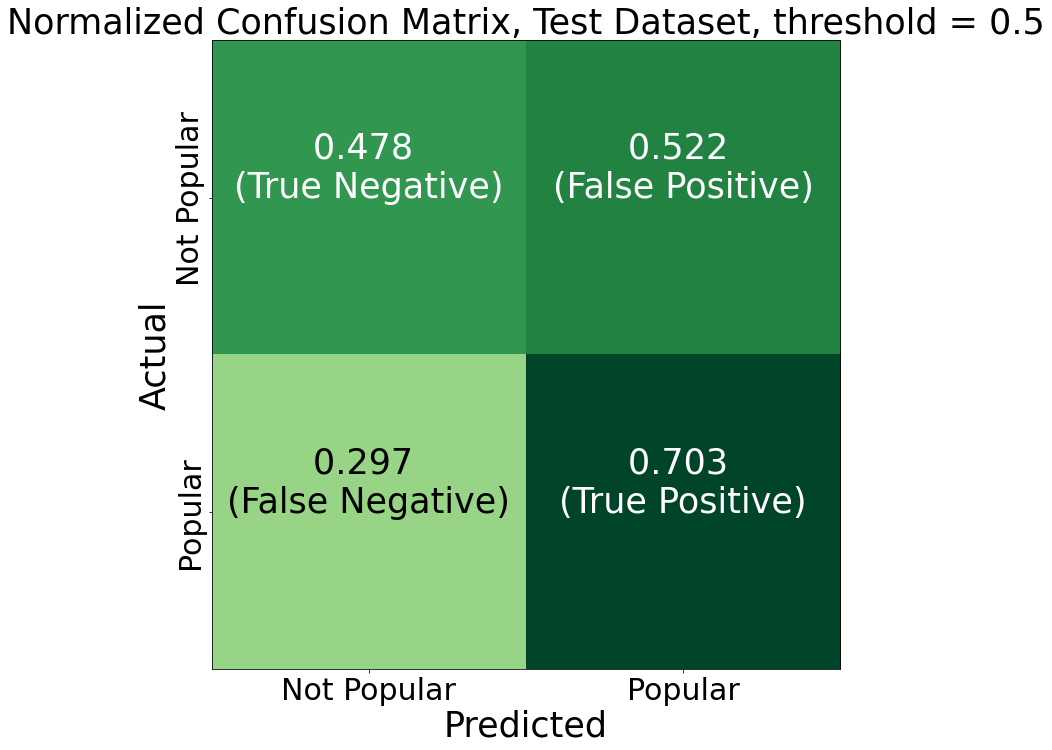

In [1234]:
# plot confusion matrix for final Test dataset
def plot_conf_matrix_Test():
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.grid(False)
    class_names = ["Not Popular","Popular"]
    plot_confusion_matrix(conf_matrix_log80_test, ax, classes=class_names,normalize=True,
                      title='Normalized Confusion Matrix, Test Dataset, threshold = 0.5')
    plt.savefig('../Confusion_Matrix_Test.png', dpi = 100)
    plt.show()
plot_conf_matrix_Test()

Normalized confusion matrix
[[0.47694524 0.52305476]
 [0.2993007  0.7006993 ]]
Normalized confusion matrix
[[0.47752809 0.52247191]
 [0.29714286 0.70285714]]


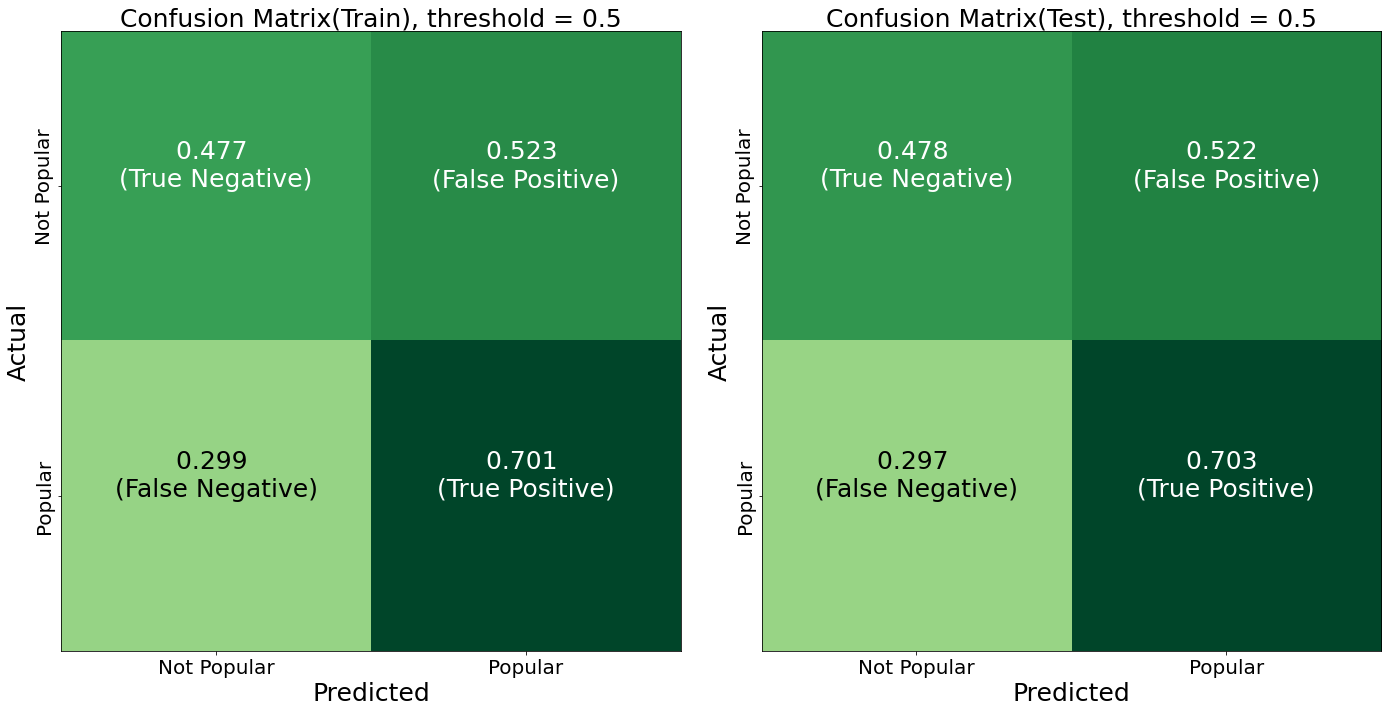

In [1220]:
def plot_conf_matrix_Train_Test():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.grid(False)
    class_names = ["Not Popular","Popular"]
    plot_confusion_matrix(conf_matrix_log80_train, ax1, classes=class_names,normalize=True,
                      title='Confusion Matrix(Train), threshold = 0.5')

    ax2.grid(False)
    class_names = ["Not Popular","Popular"]
    plot_confusion_matrix(conf_matrix_log80_test, ax2, classes=class_names,normalize=True,
                      title='Confusion Matrix(Test), threshold = 0.5')
plot_conf_matrix_Train_Test()

In [983]:
# plot final coefficients of logistic regression
def plot_final_coeffs():
    columns_bar = ['acousticness', 'danceability','duration_ms', 'energy', 'instrumentalness', 
                   'key', 'liveness','loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 
                   'valence']
    df_final_coefs = pd.DataFrame(data = final_coefs, columns = columns_bar)
    df_final_coefs.plot(kind = 'bar', figsize=(10, 5), align='edge')
    plt.show()

In [1237]:
def get_true_positives():
    # Songs my test model predicted were popular that are actually popular (true positives)
    print(df_test_results_log80[(df_test_results_log80['pop_predict_bin'] == 1) & (df_test_results_log80['pop_bin'] == 1)])

def get_true_negatives():
    # Songs my test model predicted were not popular that are not actually popular (true negatives)
    print(df_test_results_log80[(df_test_results_log80['pop_predict_bin'] == 0) & (df_test_results_log80['pop_bin'] == 0)])

def get_false_positives():
    # Songs my testodel predicted were popular that are not actually popular (false positives)
    print(df_test_results_log80[(df_test_results_log80['pop_predict_bin'] == 1) & (df_test_results_log80['pop_bin'] == 0)])
    # calculate false positive rate
    df_train_results_log80[(df_train_results_log80['pop_predict_bin'] == 1) & (df_train_results_log80['pop_bin'] == 0)].count() / df_train_results_log80[df_train_results_log80['popularity'] == 0].count()

def get_false_negatives():
    # Songs my test model predicted were not popular that are actually popular (false negatives)
    print(df_test_results_log80[(df_test_results_log80['pop_predict_bin'] == 0) & (df_test_results_log80['pop_bin'] == 1)])


In [985]:
def sanity_check_test():
    # grab a record from the results dataframe
    sanity_check_loc = df_test_results_log80[(df_test_results_log80['pop_predict_bin'] == 0) & (df_test_results_log80['popularity'] == 1)].iloc[0]
    # set the probability that song has a popularity score >=80 = sanity_check_prob
    sanity_check_prob = sanity_check_loc['pop_predict']

    # print these to make sure they make sense
    print(sanity_check_loc)
    print(sanity_check_prob)

    # this record coresponds to the 9th row of X_test within the logistic regression function (I know becuase I looked ;)
    print(sanity_check[9, :])
    
    # grab the standardized variables from X_test
    sanity_check_std_vars = sanity_check[9, :]
    print(sanity_check_std_vars)

    # multiply the standardized variables by the regression coefficients, sum them and add the intercept
    mult_coefs_vars_add_intercept = sum(sanity_check_std_vars*final_coefs.reshape(13)) + final_intercept
    print(mult_coefs_vars_add_intercept)

    # since the log odds = P / 1-P, need to exponentiate this to get to the final predicted probability
    exponentiated = np.exp(mult_coefs_vars_add_intercept)
    print(exponentiated)

    # finally, calculate P, the odds of popular (popularity score >= 80)
    p = exponentiated / (1 + exponentiated)
    print(p)

    # does this equal what we think it should???
    delta_ps = float(p - sanity_check_prob)
    print(f"Dela in p values is {delta_ps:.7f}, woo hoo!!!")

In [1216]:
global cols_to_stardardize
cols_to_standardize = ['duration_ms', 'loudness', 'tempo']

[[-0.10009023  0.41069261 -0.1031439  -0.61811743 -0.0529661   0.07481024
  -1.3104417   0.45607574 -0.18062221 -0.82510432  0.0020579   0.39823861
   0.93631382]]


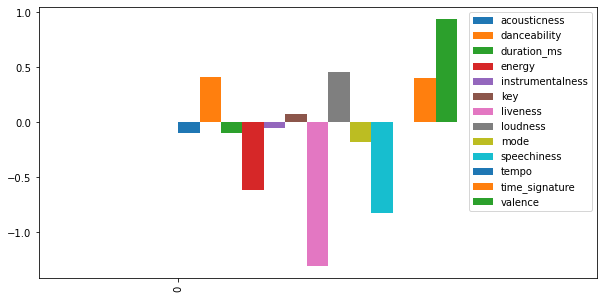

In [1023]:
print(final_coefs)
plot_final_coeffs()

In [1104]:
# get_true_positives()
# get_true_negatives()
# get_false_positives()
# get_false_negatives()
sanity_check_test()

acousticness             0.088200
danceability             0.694000
duration_ms         201253.000000
energy                   0.852000
instrumentalness         0.000000
key                      7.000000
liveness                 0.334000
loudness                -5.340000
mode                     0.000000
speechiness              0.257000
tempo                  107.178000
time_signature           4.000000
valence                  0.377000
popularity               1.000000
pop_predict              0.404751
pop_predict_bin          0.000000
Name: 17, dtype: float64
0.4047512200672781
[0.319      0.776      0.70883671 0.589      0.         9.
 0.0715     0.71528244 0.         0.115      0.00972813 4.
 0.668     ]
[0.319      0.776      0.70883671 0.589      0.         9.
 0.0715     0.71528244 0.         0.115      0.00972813 4.
 0.668     ]
[0.37030307]
[1.44817345]
[0.59153221]
Dela in p values is 0.1867810, woo hoo!!!


##  1.Do regions share the same top-ranking artists or songs?

In [542]:
def plotTopXThings(region, Things, base_on, X = 10, when = 'all'):
    """
    Things: 'Artist'/'Track Name'
    base_on: 'Position'/ 'Streams'
    when: 'all'/'2017'/'2018'
    """
    
    if when == '2017':
        d = df_2017
    else:
        d = df
        
    if base_on == 'Position':
        top = d[d['Region'] == region].loc[(d['Position'] == 1), Things].value_counts()
        top = top.to_frame().reset_index()
        top.columns = [Things, 'Counts']
        topX = top.nlargest(X,'Counts')
        
        x_axis = 'Counts'
        
    elif base_on == 'Streams':
        top = d[d['Region'] == region].groupby(Things)['Streams'].sum()
        top = top.to_frame().reset_index()
        topX = top.nlargest(X,'Streams')
        
        x_axis = 'Streams'
        

    # Declaring the figure or the plot (y, x) or (width, height)
    plt.figure(figsize = (16,10))

    plots = sns.barplot(x= x_axis, y=Things, data=topX)
    
    if base_on == 'Position':
        # Annotating the bar plot with the values (Position 1 counts)
        # Iterrating over the bars one-by-one
        for bar in plots.patches:
            # Using Matplotlib's annotate function and
            plots.annotate(format(bar.get_width(), '.0f'),
                           # passing the coordinates where the annotation shall be done
                           # x-coordinate: 3.5+bar.get_width()
                           # y-coordinate: bar.get_y() + bar.get_height()/2
                           (3.5+bar.get_width(), bar.get_y() + bar.get_height()/2),
                           # ha and va stand for the horizontal and vertical alignment
                           ha='center', va='center')

        # Setting the label for x-axis
        plt.ylabel(Things, size=18)

        # Setting the label for y-axis
        plt.xlabel("Frequency of Reaching Position 1", size=18)
        
        if X >= 50 :
            plt.yticks(fontsize=6)

        # Setting the title for the graph
        plt.title(f"Top-ranking {Things} (Region: {region})", size=22)

        # Finally showing the plot
        return plt.show()

        
    elif base_on == 'Streams':
        # Setting the label for x-axis
        plt.ylabel(Things, size=18)

        # Setting the label for y-axis
        plt.xlabel("Number of Streams", size=18)
        
        if X >= 50 :
            plt.yticks(fontsize=6)

        # Setting the title for the graph
        plt.title(f"Top-ranking {Things} (Region: {region})", size=22)

        # Finally showing the plot
        return plt.show()

### Artist

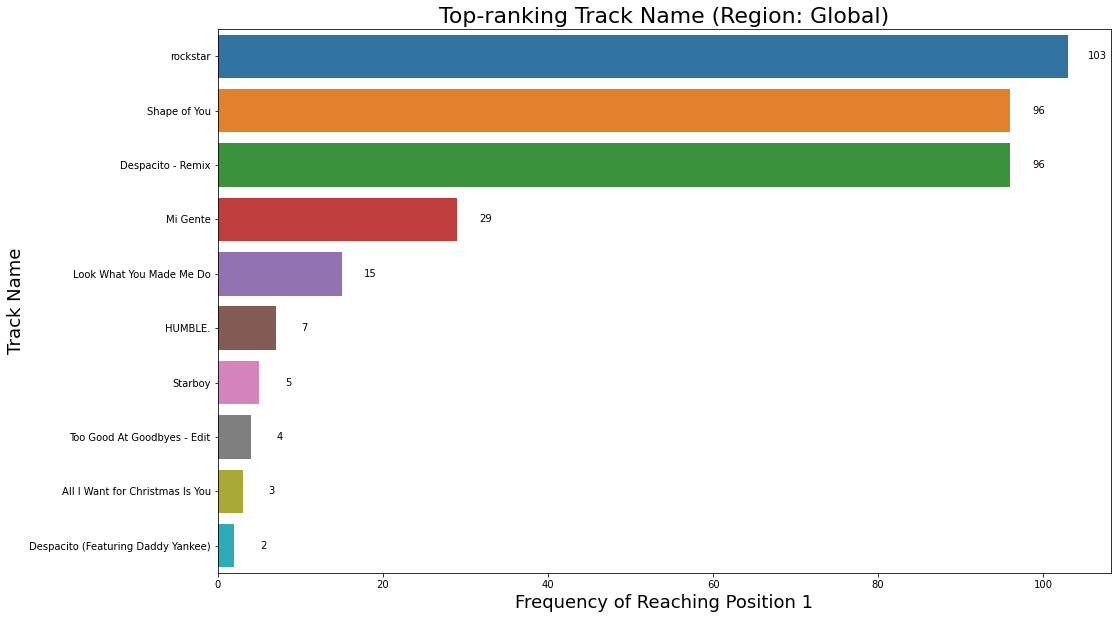

In [544]:
plotTopXThings('Global', 'Track Name', 'Position', when = '2017')
# plotTopXThings('United States of America', 'Artist', 'Streams')
# # plotTopXThings('gb', 'Artist', 'Streams')
# plotTopXThings('Japan', 'Artist', 'Streams')

### Track Name

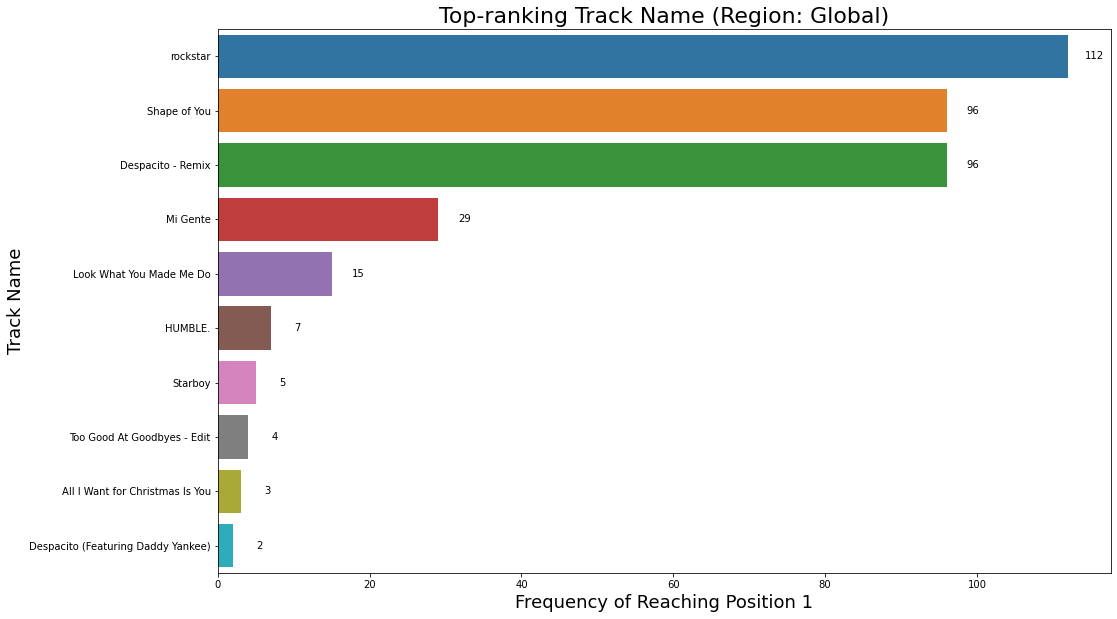

In [540]:
plotTopXThings('Global', 'Track Name', 'Position')
# plotTopXThings('us', 'Track Name', 'Streams')
# plotTopXThings('gb', 'Track Name', 'Streams')
# plotTopXThings('jp', 'Track Name', 'Streams')
# plotTopXThings('tw', 'Track Name', 'Streams')

##  2.Does the popularity of a track in one region predict its (upcoming?) popularity in other regions ?



## 4.Does reaching the top N (e.g., 5, 10, 20) positions have any relationship with the subsequent lifetime of a track in the data?

Hypothesis: The higher position means longer lifetime of a track 

In [22]:
def plotTopXTrend(region,X):
    top = df[df['Region'] == region].groupby(['Track Name','Artist'])['Streams'].sum()
    top = top.to_frame().reset_index()
    topX = top.nlargest(X,'Streams')
    topX_tracks = topX['Track Name'].values.tolist()
    topX_artists = topX['Artist'].values.tolist()
    topX_tuples = list(zip(topX_tracks,topX_artists))
    
    plt.figure(figsize = (16,10))

    for track, artist in topX_tuples:
        d = df[(df['Region'] == region) & (df['Track Name'] == track) & (df['Artist'] == artist)]
        plt.plot(d['Date'], d['Position'], label=track)
        plt.ylim([0, 50])
        plt.yticks(np.arange(1, 201, 10))
        plt.gca().invert_yaxis()
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
        plt.gcf().autofmt_xdate()
        plt.legend()

    plt.ylabel('Position', size=18)
    plt.title(f"Trend of Top {X} Tracks (Region: {region})", size=22)
    plt.show()
    


### Trends

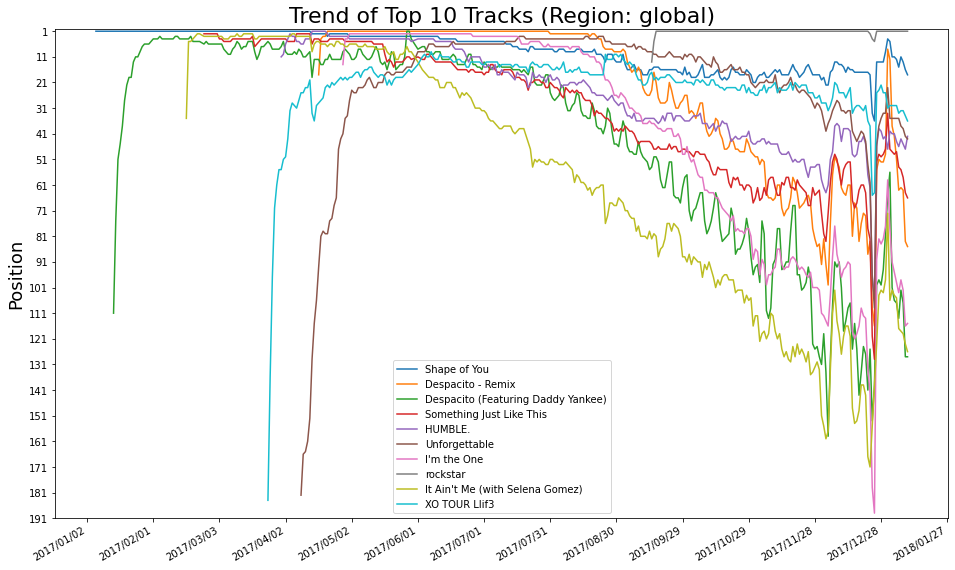

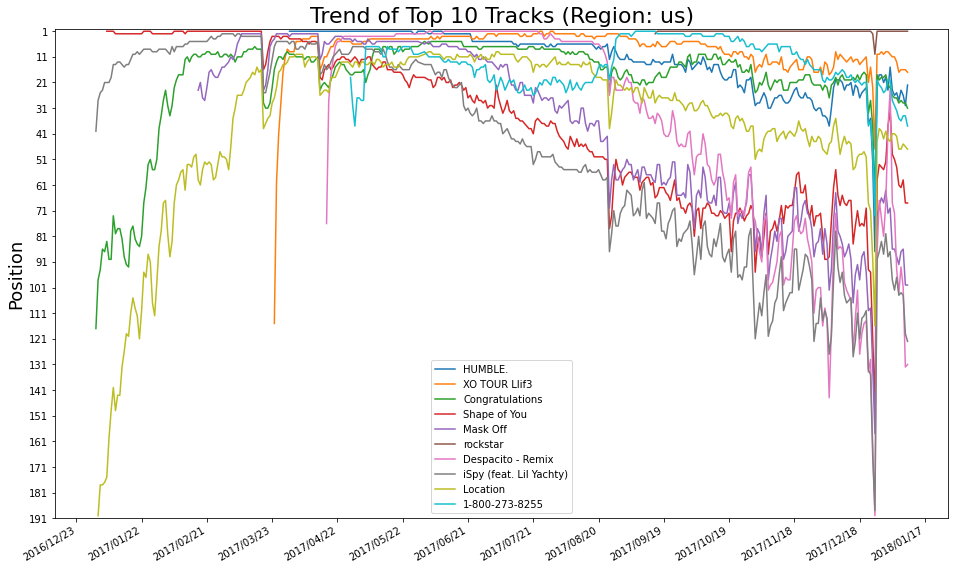

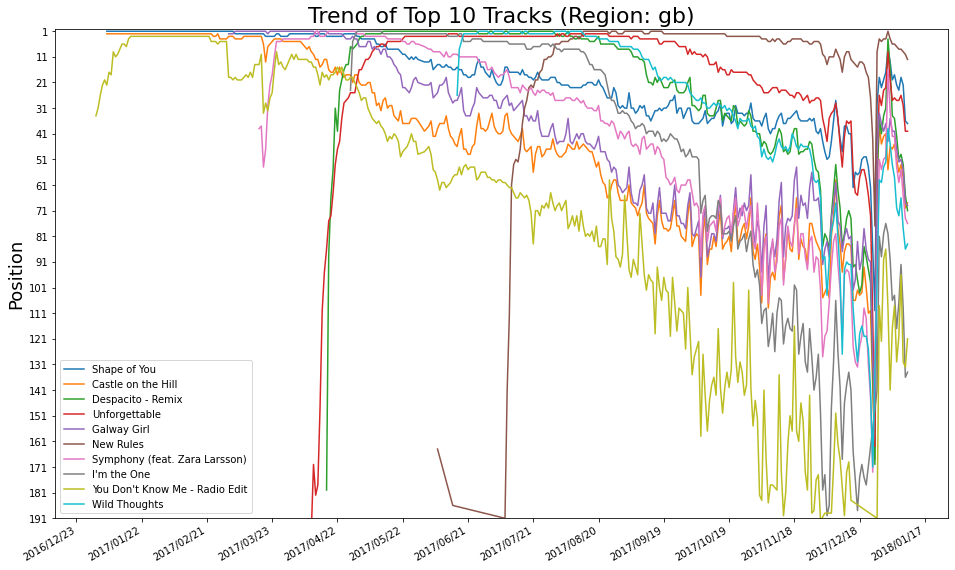

D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 25171 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 33457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 28779 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 25171 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\Anaconda\lib\site-packages\ma

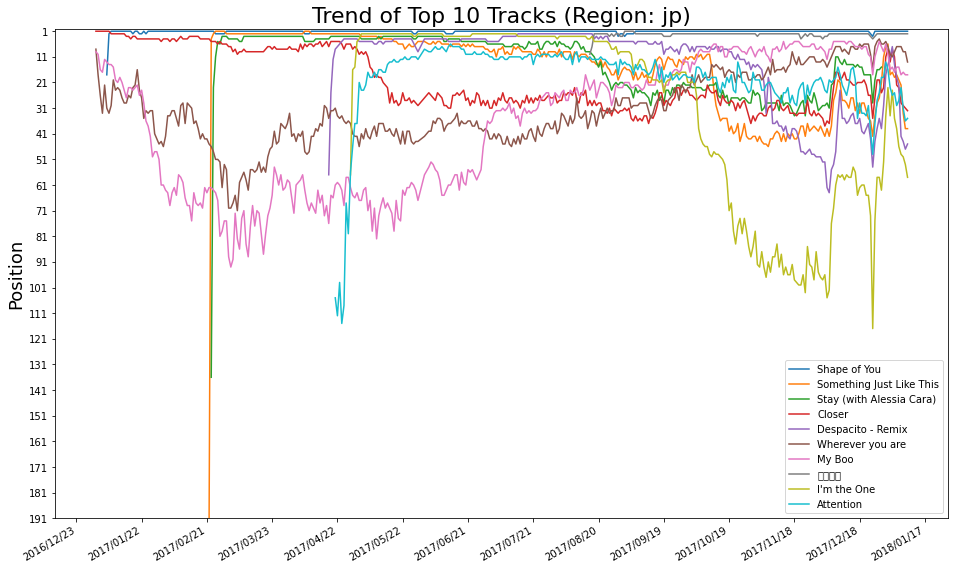

In [23]:
plotTopXTrend('global', 10)
plotTopXTrend('us', 10)
plotTopXTrend('gb', 10)
plotTopXTrend('jp', 10)

In [ ]:
df_ED = df.loc[df['Artist'] == 'Ed Sheeran',:]

df_ED["Date"] = pd.to_datetime(df_ED["Date"])
#Shorten song names
df_ED["Track Name"] = df_ED["Track Name"].apply(lambda x: x[0:15])


total_quantity_by_song_and_date = (df_ED.groupby(
    [df_ED['Date'] , 'Track Name'])['Streams'].sum()
    .reset_index().rename(columns={'Date': 'month'})
    .sort_values('month'))

# Plot the data
ch = chartify.Chart(blank_labels=True, x_axis_type='datetime')
ch.set_title("Stream count of Ed Sheeran's top tracks")
ch.plot.area(
    data_frame=total_quantity_by_song_and_date,
    x_column='month',
    y_column='Streams',
    color_column='Track Name',
    stacked=True)
ch.axes.set_yaxis_range(end = 150000000)
ch.show("png")

## Linear Regression Modeling: Rank Prediction

Multi-output regression is used to predict multiple output/target variables. Artist and streams are used to forecast average/max/min rank variables simultaneously. As tuning /fitting process, after standardizing(scaling) data, PCA is applied to find linear combinations of current predictor variables and created new "principal components". This process helped to reduce dimensionality and understand the most important "directions" in the data. However, after plotting the Linear Regression of actual vs prediction residual I realized that the outcome did not change in proportion to a change in any of the inputs, in other words, the plot indicated nonlinearity

### Simple Linear Regression withdout scaling and PCA

Training Score (R Square): 0.6641.
Testing Score (R Square): 0.654.
RMSE: 34.022.
MAE: 26.833.


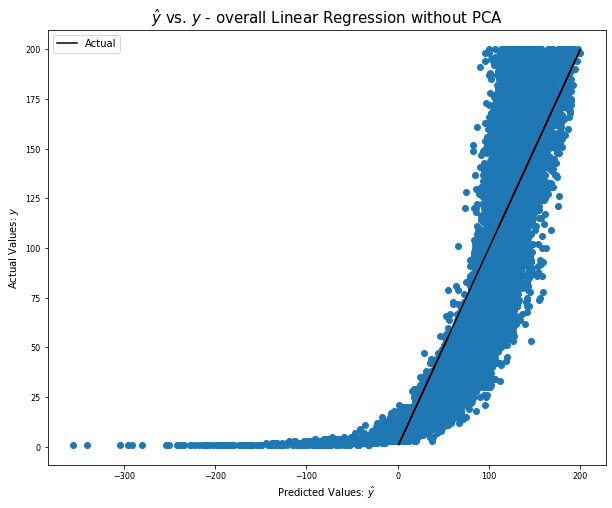

In [493]:
df_Global = df[df['Region Code']=='GLOBAL']

# Dummification of categorical variable 
df_Global_dummies = pd.get_dummies(data=df_Global , columns=['Artist'])
df_Global_dummies.set_index(pd.to_datetime(df_Global_dummies['Date']), inplace = True)

#Choosing matrix 
X = df_Global_dummies.drop(
    columns = ['Date','Year', 'Month', 'Weekday','Region Code', 'Continent', 'Position', 'Track Name', 'Region'])

# defining target
y = df_Global_dummies['Position']

# split data into train/test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### Simple Linear Regression ###

#Instantiate and fitting model
lm = LinearRegression()
lm.fit(X_train, y_train)
print(f'Training Score (R Square): {round(lm.score(X_train, y_train),4)}.')
print(f'Testing Score (R Square): {round(lm.score(X_test, y_test),4)}.')

#Look into predictions 
y_pred_train= lm.predict(X_train)
y_pred_test = lm.predict(X_test)
print(f'RMSE: {round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),3)}.')
print(f'MAE: {round(metrics.mean_absolute_error(y_test,y_pred_test),3)}.')

# Plotting to compare actual vs prediction
plt.figure(figsize = (10,8))
plt.scatter(y_pred_test,y_test)
plt.plot( y_test,y_test, c = 'black')
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 10)
plt.ylabel("Actual Values: $y$", fontsize = 10)
plt.title("$\hat{y}$ vs. $y$ - overall Linear Regression without PCA", fontsize = 15)
plt.legend(['Actual'])
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.savefig('../LinearRegression.png', dpi = 100)

In [124]:
# model = sm.GLM(y_train, X_train, family = sm.families.Poisson(link = sm.families.links.log)).fit()
# poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
# model.summary()

<ipython-input-124-8f5c6b2a402a>:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  model = sm.GLM(y_train, X_train, family = sm.families.Poisson(link = sm.families.links.log)).fit()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Position   No. Observations:                55338
Model:                            GLM   Df Residuals:                    54896
Model Family:                 Poisson   Df Model:                          441
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3110e+05
Date:                Sat, 02 Apr 2022   Deviance:                   1.2133e+05
Time:                        15:44:06   Pearson chi2:                 1.91e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Streams                                          -1.448e-06   1.52e-09   -952.863      0.000   -1.45e-06   -1.44e-06
Artist_*NSYNC                                        6.1244      0.054    114.048      0.000       6.019       6.230
Artist_187 Strassenbande                             5.7885      0.037    156.784      0.000       5.716       5.861
Artist_2 Chainz                                      5.7368      0.007    861.783      0.000       5.724       5.750
Artist_21 Savage                                     5.7413      0.006   1021.943      0.000       5.730       5.752
Artist_22 Savage                                     5.8985      0.024    249.922      0.000       5.852       5.945
Artist_6LACK                                         5.8601      0.036    161.206      0.000       5.789       5.931
Artist_6ix9ine                                       5.9660      0.014    426.123      0.000       5.939       5.993
Artist_A Boogie Wit da Hoodie                        5.7640      0.006    887.034      0.000       5.751       5.777
Artist_A R I Z O N A                                 5.7143      0.011    501.152      0.000       5.692       5.737
Artist_A$AP Ferg                                     5.7683      0.012    497.784      0.000       5.746       5.791
Artist_A$AP Mob                                      6.0609      0.071     85.709      0.000       5.922       6.200
Artist_AC/DC                                         5.9715      0.045    132.832      0.000       5.883       6.060
Artist_AJR                                           5.7469      0.008    702.114      0.000       5.731       5.763
Artist_ALMA                                          5.8456      0.086     68.167      0.000       5.678       6.014
Artist_Aaron Carter                                  5.7417      0.013    433.410      0.000       5.716       5.768
Artist_Abraham Mateo                                 5.8266      0.008    691.886      0.000       5.810       5.843
Artist_Adele                                         5.7326      0.006    919.945      0.000       5.720       5.745
Artist_Alan Walker                                   5.7656      0.004   1296.685      0.000       5.757       5.774
Artist_Alejandro Fernandez                           5.9260      0.050    117.766      0.000       5.827       6.025
Artist_Alessia Cara                                  5.7792      0.006    967.073      0.000       5.767       5.791
Artist_Alesso                                        5.9130      0.017    346.430      0.000       5.880       5.946
Artist_Alex Sensation                                5.6920      0.011    522.344      0.000       5.671       5.713
Artist_Alok                              

### Linear Regression with Scaling & PCA

Training Score (R Square): 0.5587.
Testing Score (R Square): 0.5543.
RMSE: 38.614.
MAE: 31.458.


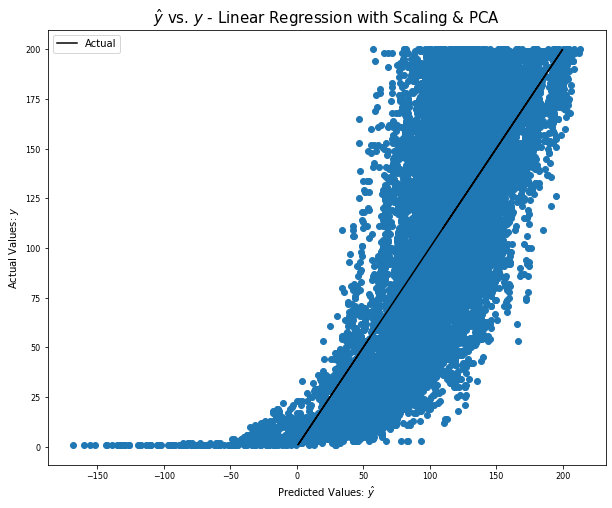

In [494]:
df_Global = df[df['Region Code']=='GLOBAL']

# Dummification of categorical variable 
df_Global_dummies = pd.get_dummies(data=df_Global , columns=['Artist'])
df_Global_dummies.set_index(pd.to_datetime(df_Global_dummies['Date']), inplace = True)

#Choosing matrix 
X = df_Global_dummies.drop(
    columns = ['Date','Year', 'Month', 'Weekday','Region Code', 'Continent', 'Position', 'Track Name', 'Region'])

# defining target
y = df_Global_dummies['Position']

# split data into train/test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### Linear Regression with Scaling & PCA ###

#Scaling data before running PCA
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

#Instantiate and fit PCA
pca = PCA(n_components=0.9).fit(X_train)

#Instantiate and fitting model
lm = LinearRegression()
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)
lm.fit(Z_train, y_train)
print(f'Training Score (R Square): {round(lm.score(Z_train, y_train),4)}.')
print(f'Testing Score (R Square): {round(lm.score(Z_test, y_test),4)}.')

#Look into predictions 
y_pred_train= lm.predict(Z_train)
y_pred_test = lm.predict(Z_test)
print(f'RMSE: {round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),3)}.')
print(f'MAE: {round(metrics.mean_absolute_error(y_test,y_pred_test),3)}.')

# Plotting to compare actual vs prediction
plt.figure(figsize = (10,8))
plt.scatter(y_pred_test,y_test)
plt.plot( y_test,y_test, c = 'black')
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 10)
plt.ylabel("Actual Values: $y$", fontsize = 10)
plt.title("$\hat{y}$ vs. $y$ - Linear Regression with Scaling & PCA", fontsize = 15)
plt.legend(['Actual'])
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.savefig('../LinearRegression.png', dpi = 100)

## Multivariate Linear Regression

### Data Wrangling for Multivariate Linear Regression

In [495]:
# creating new columns/dataframe to be used as matrix for our models
new_cols_rank = df_Global.groupby(['Date','Artist', 'Region']).agg({'Position': ['mean', 'min', 'max']})
new_cols_rank.columns = ['Average Rank', 'Hignest Rank', 'Lowest Rank']

# creating new columns/dataframe to be used as matrix for our models for ranks 
new_cols_streams = df_Global.groupby(['Date', 'Artist','Region']).agg({'Streams': ['mean', 'max', 'min']})
new_cols_streams.columns = ['Average Streams', 'Maximum Streams', 'Minimum Streams']

# merging two DF for consolidated data
df_Global_new = pd.merge(new_cols_rank, new_cols_streams, on =['Date', 'Region', 'Artist'])
df_Global_new.reset_index(level=['Region','Artist'], inplace = True)

# dummification of categorical variable
df_Global_new_dummies = pd.get_dummies(data=df_Global_new, columns=['Artist'])

In [501]:
# Choosing target
y_new = df_Global_new_dummies[['Lowest Rank', 'Hignest Rank', 'Average Rank']]

X_new = df_Global_new_dummies.drop(
    columns = ['Region', 'Lowest Rank', 'Hignest Rank', 'Average Rank'])

# split data into test/train sets 
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, random_state = 42)

# Scaling data for PCA 
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

# Instantiate PCA and fitting
pca = PCA(n_components=0.9).fit(X_train)

### Model: Multivariate Linear Regression with only Scaling & PCA

In [502]:
# Tune & fit model 
mlr_model = MultiOutputRegressor(LinearRegression())
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)
mlr_model.fit(Z_train, y_train)
print(f'Training Score (R Square Score): {round(mlr_model.score(Z_train, y_train),4)}.')
print(f'Testing Score (R Square Score): {round(mlr_model.score(Z_test, y_test),4)}.')

#Look into predictions 
y_pred_train= mlr_model.predict(Z_train)
y_pred_test = mlr_model.predict(Z_test)
print(f'RMSE of Trainng set: {round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)),3)}.')
print(f'RMSE of Testing set: {round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),3)}.')
print(f'MAE of Trainng set: {round(metrics.mean_absolute_error(y_train,y_pred_train),3)}.')
print(f'MAE of Testing set: {round(metrics.mean_absolute_error(y_test,y_pred_test),3)}.')

Training Score (R Square Score): 0.7165.
Testing Score (R Square Score): 0.7071.
RMSE of Trainng set: 29.58.
RMSE of Testing set: 30.163.
MAE of Trainng set: 23.052.
MAE of Testing set: 23.493.


### Model: Multivariate Linear Regression with RandomForest Regressor 

In [505]:
#Tuning model & Fit it 
mlr_model_rf = MultiOutputRegressor(RandomForestRegressor())
Z_train_rf = pca.transform(X_train)
Z_test_rf = pca.transform(X_test)
mlr_model_rf.fit(Z_train_rf, y_train)
print(f'Training Score (R Square Score): {round(mlr_model_rf.score(Z_train_rf, y_train),4)}.')
print(f'Testing Score (R Square Score): {round(mlr_model_rf.score(Z_test_rf, y_test),4)}.')

# Look into predictions 
y_pred_train_rf= mlr_model_rf.predict(Z_train_rf)
y_pred_test_rf = mlr_model_rf.predict(Z_test_rf)
print(f'RMSE of Testing set: {round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_rf)),3)}.')
print(f'RMSE of Trainng set: {round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_rf)),3)}.')
print(f'MAE of Testing set: {round(metrics.mean_absolute_error(y_test,y_pred_test_rf),3)}.')
print(f'MAE of Trainng set: {round(metrics.mean_absolute_error(y_train,y_pred_train_rf),3)}.')

Training Score (R Square Score): 0.9932.
Testing Score (R Square Score): 0.9478.
RMSE of Testing set: 12.662.
RMSE of Trainng set: 4.573.
MAE of Testing set: 8.372.
MAE of Trainng set: 3.035.


### Models Comparison

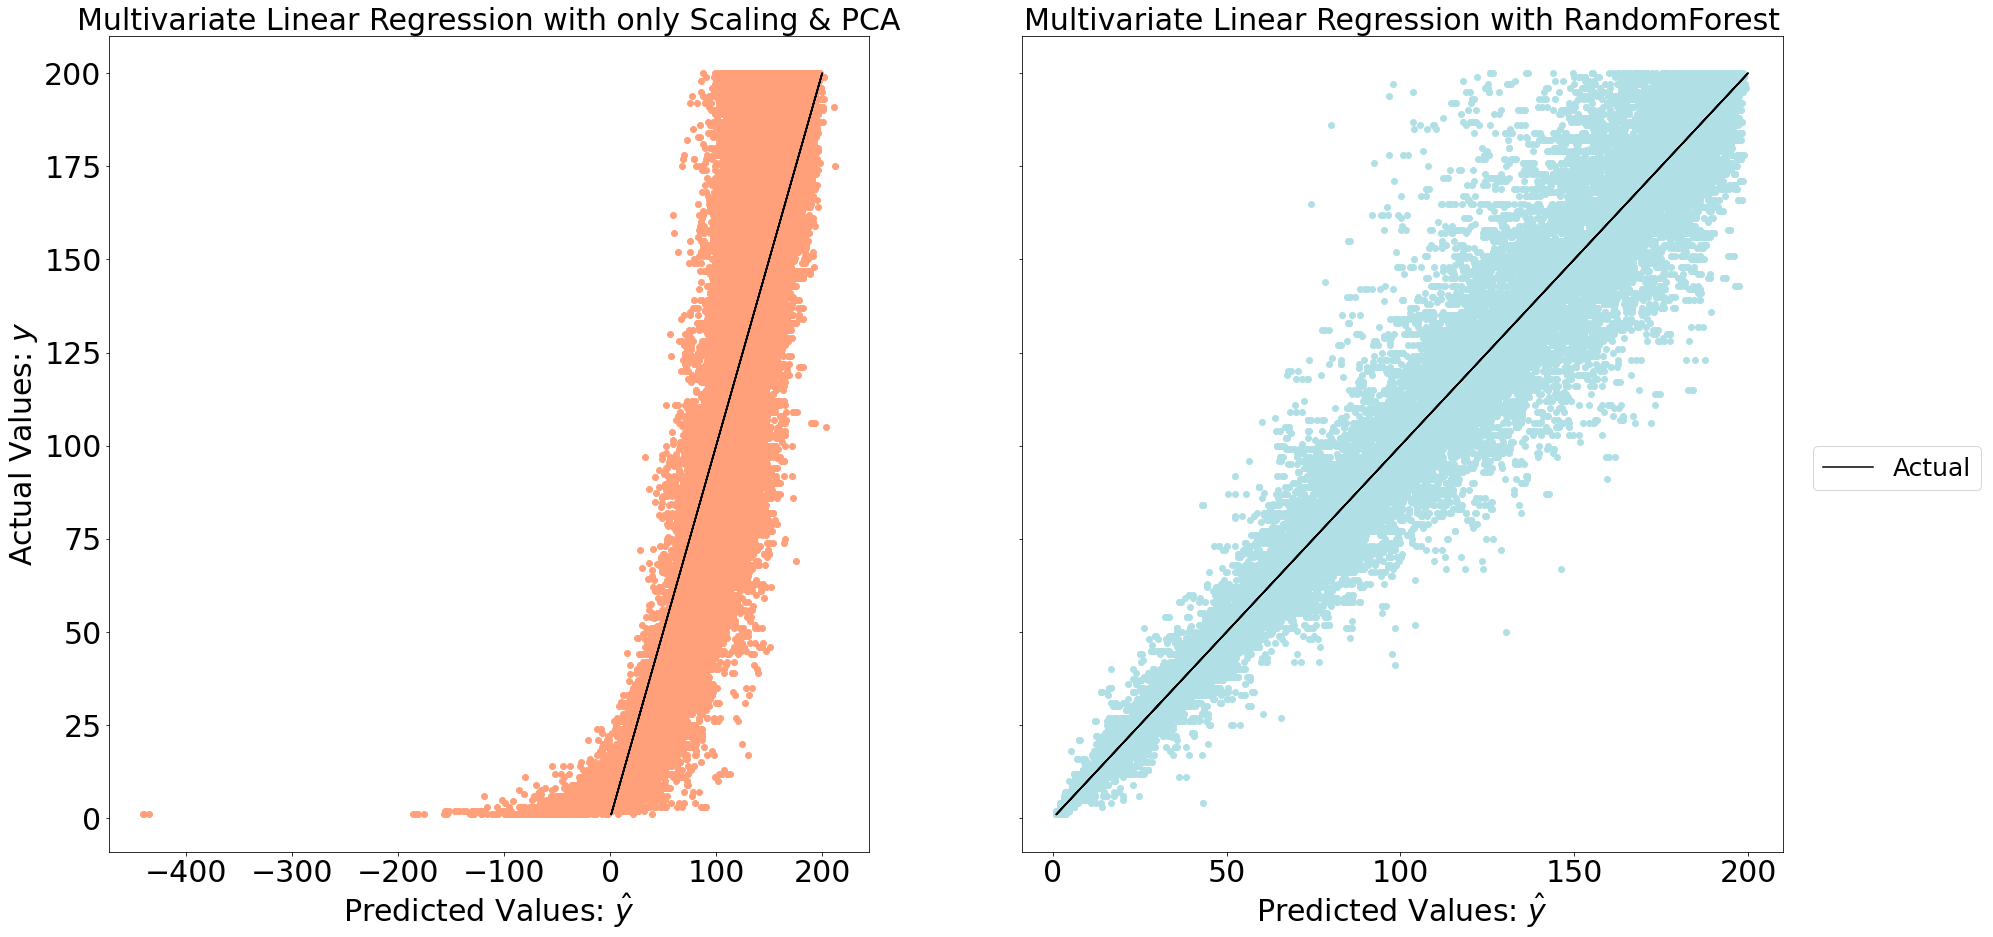

In [578]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15), sharey=True)

### Plotting to compare actual vs preds for Multivariate Linear Regression with only Scaling & PCA
ax1.scatter(y_pred_test, y_test, c = 'lightsalmon')
ax1.plot(y_test, y_test, c = 'black')
ax1.set_title("Multivariate Linear Regression with only Scaling & PCA", fontsize = 30)
ax1.set_xlabel("Predicted Values: $\hat{y}$", fontsize=30)
ax1.set_ylabel("Actual Values: $y$", fontsize=30)
ax1.yaxis.set_tick_params(labelsize=30)
ax1.xaxis.set_tick_params(labelsize=30)

### Plotting to compare actual vs preds for Multivariate Linear Regression with RandomForest Regressor 
ax2.scatter(y_pred_test_rf, y_test, c = 'powderblue')
ax2.plot(y_test, y_test, c = 'black')
ax2.set_title("Multivariate Linear Regression with RandomForest", fontsize =30)
ax2.set_xlabel("Predicted Values: $\hat{y}$", fontsize=30)
ax2.yaxis.set_tick_params(labelsize=30)
ax2.xaxis.set_tick_params(labelsize=30)

fig.legend(['Actual'],loc='center right', fontsize=25)
fig.savefig('../residual_rank_rf_overall.png', dpi = 100)

### Model: Multivariate Linear Regression with RandomForest Regressor But No Scaling&PCA

Training Score (R Square Score): 0.9927.
Testing Score (R Square Score): 0.9464.
RMSE of Testing set: 12.84.
RMSE of Trainng set: 4.72.
MAE of Testing set: 8.658.
MAE of Trainng set: 3.165.


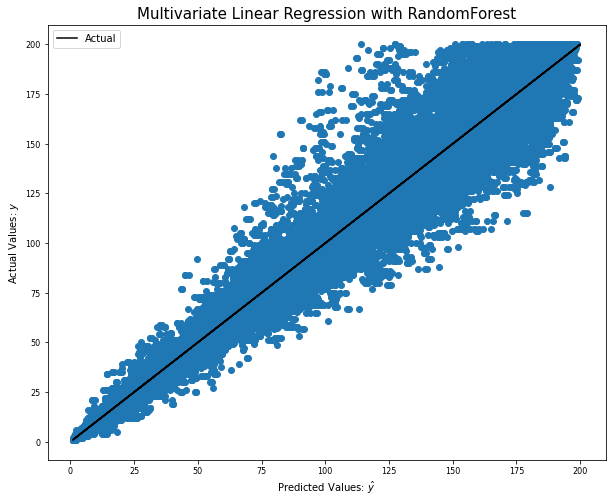

In [500]:
# Choosing target
y_new = df_Global_new_dummies[['Lowest Rank', 'Hignest Rank', 'Average Rank']]

X_new = df_Global_new_dummies.drop(
    columns = ['Region', 'Lowest Rank', 'Hignest Rank', 'Average Rank'])

# split data into test/train sets 
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, random_state = 42)

#Tuning model & Fit it 
rf = MultiOutputRegressor(RandomForestRegressor())
rf.fit(X_train, y_train)
print(f'Training Score (R Square Score): {round(rf.score(X_train, y_train),4)}.')
print(f'Testing Score (R Square Score): {round(rf.score(X_test, y_test),4)}.')

# Look into predictions 
y_pred_train_rf= rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)
print(f'RMSE of Testing set: {round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_rf)),3)}.')
print(f'RMSE of Trainng set: {round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_rf)),3)}.')
print(f'MAE of Testing set: {round(metrics.mean_absolute_error(y_test,y_pred_test_rf),3)}.')
print(f'MAE of Trainng set: {round(metrics.mean_absolute_error(y_train,y_pred_train_rf),3)}.')

# Plotting to compare actual vs preds for average rank 
plt.figure(figsize = (10,8))
plt.scatter(y_pred_test_rf,y_test);
plt.plot( y_test,y_test, c = 'black');
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 10);
plt.ylabel("Actual Values: $y$", fontsize = 10);
plt.title("Multivariate Linear Regression without RandomForest", fontsize = 15);
plt.legend(['Actual']);
plt.yticks(fontsize=8)
plt.xticks(fontsize=8);
plt.savefig('../residual_overall_random_forest.png', dpi = 100)

In [582]:
preds_test_rf = pd.DataFrame(y_pred_test_rf)
preds_test_rf.columns=['Average Rank Prediction', 'Hignest Rank Prediction', 'Lowest Rank Prediction']

preds_train_rf = pd.DataFrame(y_pred_test_rf)
preds_train_rf.columns=['Average Rank Prediction', 'Hignest Rank Prediction', 'Lowest Rank Prediction']

In [583]:
# selecting relevant column for seperate assessment
y_test_avg = y_test['Average Rank']
y_test_hi = y_test['Hignest Rank']
y_test_low = y_test['Lowest Rank']

y_train_avg = y_train['Average Rank']
y_train_hi = y_train['Hignest Rank']
y_train_low = y_train['Lowest Rank']

# creating Dataframe for predictions
y_pred_test_avg = preds_test_rf['Average Rank Prediction']
y_pred_test_hi = preds_test_rf['Hignest Rank Prediction']
y_pred_test_low = preds_test_rf['Lowest Rank Prediction']

y_pred_train_avg = preds_train_rf['Average Rank Prediction']
y_pred_train_hi = preds_train_rf['Hignest Rank Prediction']
y_pred_train_low = preds_train_rf['Lowest Rank Prediction']

Text(0.5, 0.98, 'Rank Prediction by using Random Forest')

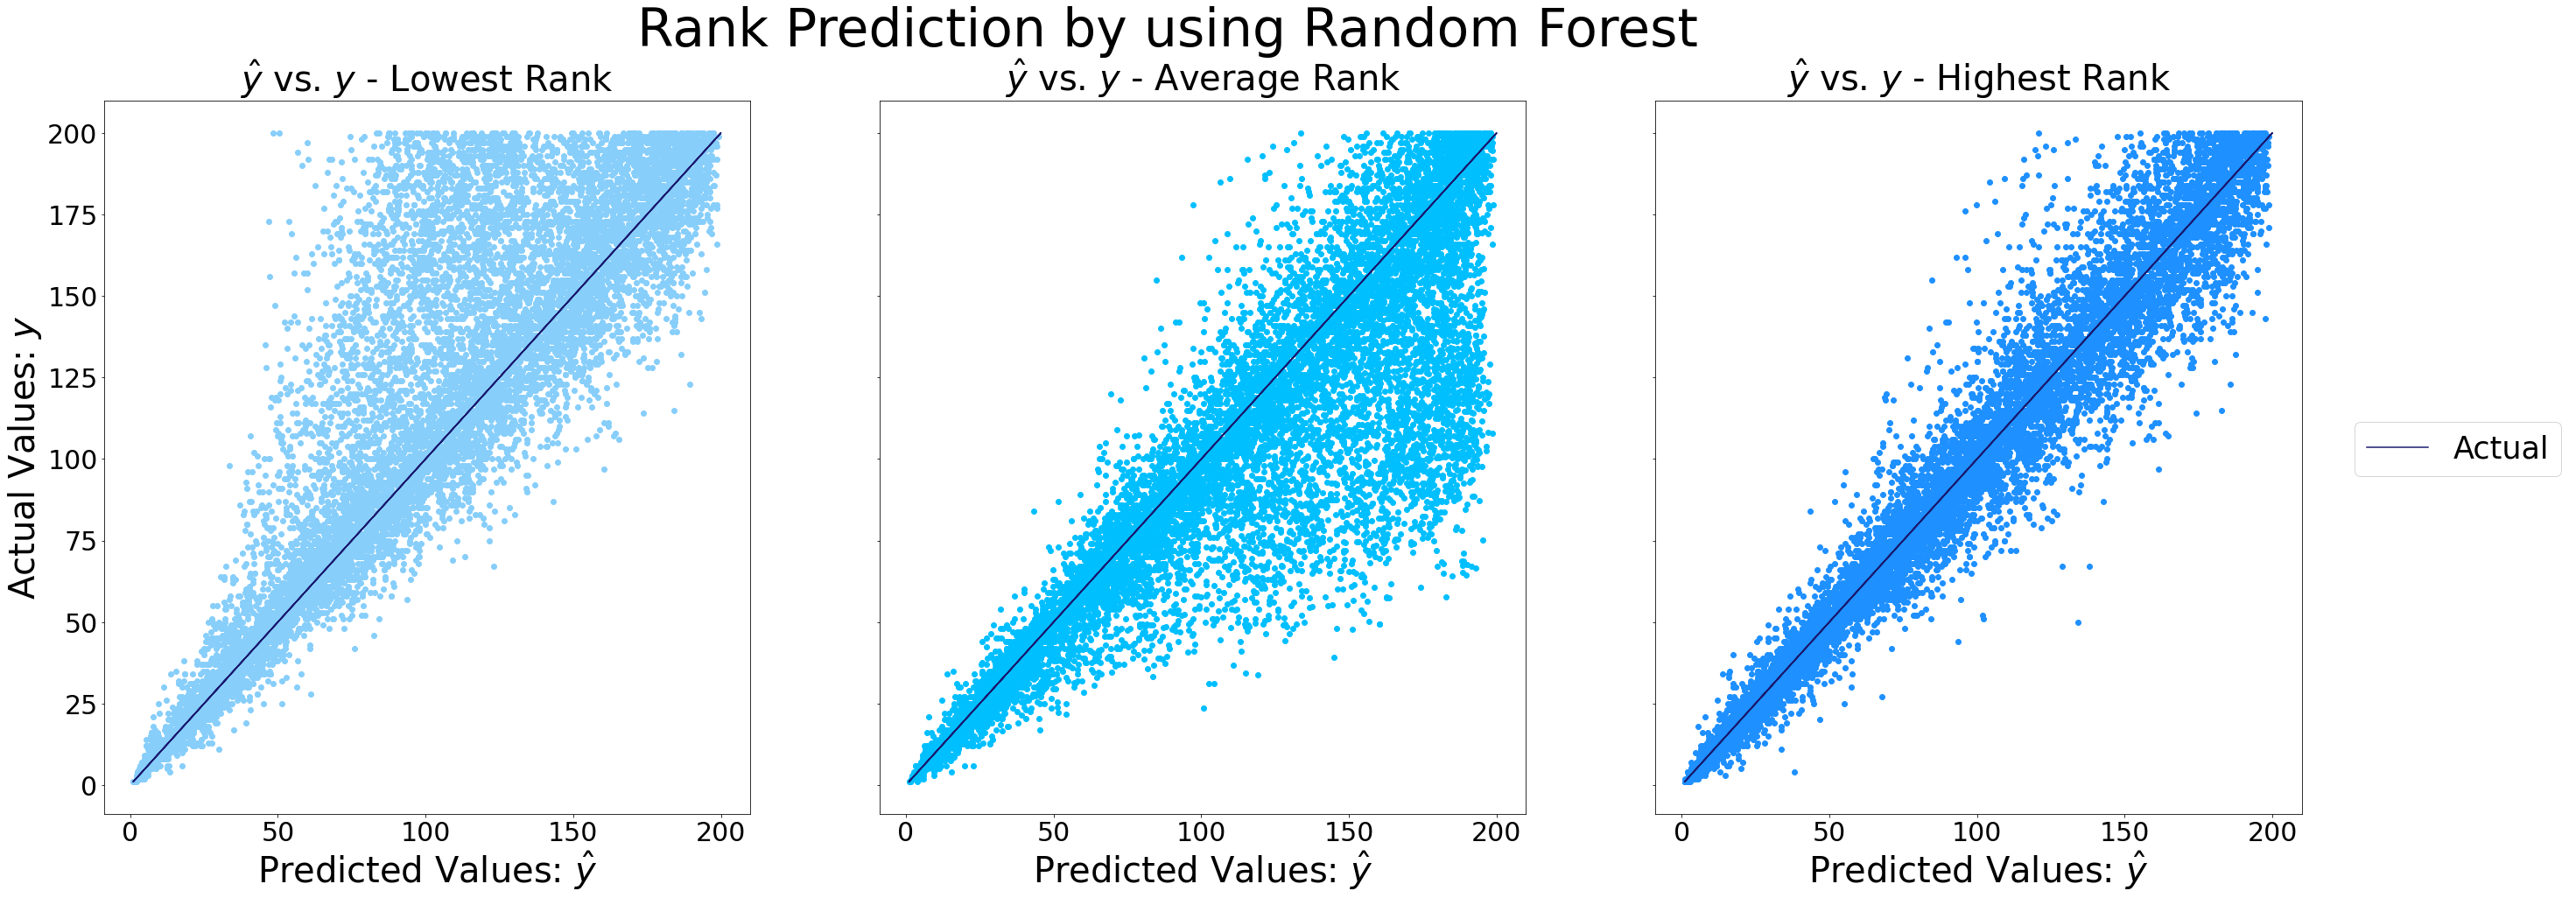

In [579]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(45, 15), sharey=True)

### Plotting to compare actual vs preds for low rank 
ax1.scatter(y_pred_test_low,y_test_low, c = 'lightskyblue')
ax1.plot( y_test,y_test, c = 'midnightblue')
ax1.set_title("$\hat{y}$ vs. $y$ - Lowest Rank", fontsize = 40)
ax1.set_xlabel("Predicted Values: $\hat{y}$", fontsize=40)
ax1.set_ylabel("Actual Values: $y$", fontsize=40)
ax1.yaxis.set_tick_params(labelsize=30)
ax1.xaxis.set_tick_params(labelsize=30)

### Plotting to compare actual vs preds for avg rank 
ax2.scatter(y_pred_test_avg,y_test_avg, c = 'deepskyblue')
ax2.plot( y_test,y_test, c = 'midnightblue')
ax2.set_title("$\hat{y}$ vs. $y$ - Average Rank", fontsize = 40)
ax2.set_xlabel("Predicted Values: $\hat{y}$", fontsize=40)
ax2.yaxis.set_tick_params(labelsize=30)
ax2.xaxis.set_tick_params(labelsize=30)

### Plotting to compare actual vs preds for highest rank 
ax3.scatter(y_pred_test_hi,y_test_hi, c = 'dodgerblue')
ax3.plot( y_test,y_test, c = 'midnightblue')
ax3.set_title("$\hat{y}$ vs. $y$ - Highest Rank", fontsize = 40)
ax3.set_xlabel("Predicted Values: $\hat{y}$", fontsize=40)
ax3.yaxis.set_tick_params(labelsize=30)
ax3.xaxis.set_tick_params(labelsize=30)

fig.legend(['Actual'],loc='center right', fontsize=35)
fig.savefig('../residual_rank_rf.png', dpi = 100)
fig.suptitle('Rank Prediction by using Random Forest', fontsize=60)

There are 3 main metrics for model evaluation in regression:
* R Square/Adjusted R Square
* Mean Square Error(MSE)/Root Mean Square Error(RMSE)
* Mean Absolute Error(MAE)

In [585]:
print('RMSE Train - Overall:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_rf)))
print('RMSE Test - Overall:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_rf)))
# print('RMSE Train - Average Rank:', np.sqrt(metrics.mean_squared_error(y_train_avg, y_pred_train_avg)))
print('RMSE Test - Average Rank:', np.sqrt(metrics.mean_squared_error(y_test_avg, y_pred_test_avg)))
# print('RMSE Train - Top Rank:', np.sqrt(metrics.mean_squared_error(y_train_avg, y_pred_train_hi)))
print('RMSE Test - Top Rank:',np.sqrt(metrics.mean_squared_error(y_test_hi, y_pred_test_hi)))
# print('RMSE Train -Low Rank:',np.sqrt(metrics.mean_squared_error(y_train_low, y_pred_train_low)))
print('RMSE Test -Low Rank:',np.sqrt(metrics.mean_squared_error(y_test_low, y_pred_test_low)))



RMSE Train - Overall: 4.573359330555962
RMSE Test - Overall: 12.661631754327848
RMSE Test - Average Rank: 29.703908779150375
RMSE Test - Top Rank: 12.09384219586228
RMSE Test -Low Rank: 30.61832261087303


#### Mean Absolute Error

In [586]:
# TRAIN - Mean Absolute Error represents median distance from the predicted value.
metrics.mean_absolute_error(y_train,y_pred_train_rf)

3.0347576274091943

In [587]:
#TEST - Mean Absolute Error represents median distance from the predicted value.
metrics.mean_absolute_error(y_test,y_pred_test_rf)

8.372494540674227

## Clustering
Here is some unsupervised learning analysis. Each song in the data set will be a feature. The value will be the percentage of plays for each song by country

In [590]:
# create the features by first calculating percentage of plays in a country for each song
cluster = df.copy()
cluster['Artist_Trackname'] = cluster['Artist'] + ' ' + cluster['Track Name']

# get the total plays for each track by country
cluster['Total_Song_Plays'] = cluster.groupby(['Region', 'Artist_Trackname'])['Streams'].transform('sum')

# get the total plays in total for each country
cluster['Total_Plays'] = cluster.groupby(['Region'])['Streams'].transform('sum')

# drop duplicate rows
cluster = cluster[['Artist_Trackname', 'Total_Song_Plays', 'Total_Plays', 'Region', 'Continent','Region Code']].drop_duplicates()

# calculate the percentage of plays that were for each song
cluster['Percent_Plays'] = cluster['Total_Song_Plays'] / cluster['Total_Plays']

# pivot the table to get the features
cluster = cluster.pivot(index='Region Code', columns='Artist_Trackname', values='Percent_Plays')

# pivot table creates NaN values when there is no value. In reality, these values should be zero.
cluster = cluster.fillna(0)

cluster

Artist_Trackname  #TocoParaVos Bailemos juntos  \
Region Code                                      
AR                                    0.000000   
AT                                    0.000000   
AU                                    0.000000   
BE                                    0.000000   
BO                                    0.000000   
BR                                    0.000000   
CA                                    0.000000   
CH                                    0.000000   
CL                                    0.000000   
CO                                    0.000000   
CR                                    0.000000   
CZ                                    0.000000   
DE                                    0.000000   
DK                                    0.000000   
DO                                    0.000000   
EC                                    0.000000   
EE                                    0.000000   
ES                                    0.000000   
FI                                    0.000000   
FR                                    0.000000   
GB                                    0.000000   
GLOBAL                                0.000000   
GR                                    0.000000   
GT                                    0.000000   
HK                                    0.000000   
HN                                    0.000000   
HU                                    0.000000   
ID                                    0.000000   
IE                                    0.000000   
IS                                    0.000000   
IT                                    0.000000   
JP                                    0.000000   
LT                                    0.000000   
LU                                    0.000000   
LV                                    0.000000   
MX                                    0.000000   
MY                                    0.000000   
NL                                    0.000000   
NO                                    0.000000   
NZ                                    0.000000   
PA                                    0.000000   
PE                                    0.000000   
PH                                    0.000000   
PL                                    0.000000   
PT                                    0.000000   
PY                                    0.000000   
SE                                    0.000000   
SG                                    0.000000   
SK                                    0.000000   
SV                                    0.000000   
TR                                    0.000000   
TW                                    0.000000   
US                                    0.000000   
UY                                    0.000005   

Artist_Trackname  #TocoParaVos Enganchado #TocoParaVos - Cumbia Mix  \
Region Code                                                           
AR                                                         0.000014   
AT                                                         0.000000   
AU                                                         0.000000   
BE                                                         0.000000   
BO                                                         0.000000   
BR                                                         0.000000   
CA                                                         0.000000   
CH                                                         0.000000   
CL                                                         0.000000   
CO                                                         0.000000   
CR                                                         0.000000   
CZ                                                         0.000000   
DE                                                         0.000000   
DK                                                         0.000000   
DO                                                         0.00

In [622]:
pca = PCA(n_components=3)
pca_features = pca.fit_transform(cluster)
Region_code = cluster.index
pca_results = pd.DataFrame(pca_features, columns=['f1', 'f2','f3'])
pca_results['Region Code'] = Region_code
pca_results['Continent'] = pca_results['Region Code'].apply(getContinentName)
pca_results['Region Name'] = pca_results['Region Code'].apply(getRegionName)

# Replace the abbreviation of continent with corresponding full names
pca_results['Continent'] = pca_results['Continent'].replace({'AS':'Asia', 'EU':'Europe', 'NA':'North America',
                                          'OC':'Oceania','SA':'South America'})

# Reduce the length of some region names
pca_results['Region'] = pca_results['Region Name'].replace({'Bolivia, Plurinational State of':'Bolivia', 
                                     'Taiwan, Province of China':'Taiwan',
                                     'United States':'United States of America'})

pca_results =  pca_results.loc[(pca_results['Continent'] != 'Global')]
pca_results

f1        f2        f3 Region Code      Continent  \
0   0.053687  0.002267 -0.001721          AR  South America   
1  -0.019797 -0.006728 -0.005807          AT         Europe   
2  -0.024785 -0.011558  0.000495          AU        Oceania   
3  -0.021072 -0.003217 -0.002809          BE         Europe   
4   0.059860  0.012930  0.002208          BO  South America   
5  -0.002579 -0.022316 -0.006956          BR  South America   
6  -0.021079 -0.010443 -0.008710          CA  North America   
7  -0.016166  0.000599 -0.006045          CH         Europe   
8   0.055789 -0.000266 -0.001535          CL  South America   
9   0.047901  0.005299  0.001750          CO  South America   
10  0.037829  0.005583  0.002560          CR  North America   
11 -0.023241 -0.003121  0.001826          CZ         Europe   
12 -0.016980 -0.008979 -0.009127          DE         Europe   
13 -0.018319 -0.011132 -0.005627          DK         Europe   
14  0.043306  0.000647 -0.001828          DO  North America   
15  0.050828  0.003801  0.000648          EC  South America   
16 -0.039600  0.030984 -0.000281          EE         Europe   
17  0.038565  0.006333 -0.002851          ES         Europe   
18 -0.011396 -0.018725 -0.009958          FI         Europe   
19 -0.008883 -0.016188 -0.013217          FR         Europe   
20 -0.021916 -0.008890 -0.004142          GB         Europe   
22 -0.032295  0.010697 -0.006109          GR         Europe   
23  0.049307  0.003102  0.002267          GT  North America   
24 -0.017737 -0.011216  0.018334          HK           Asia   
25  0.051855  0.013003  0.002678          HN  North America   
26 -0.023489  0.003274 -0.001582          HU         Europe   
27 -0.021793 -0.010236  0.025985          ID           Asia   
28 -0.024253 -0.007405 -0.000913          IE         Europe   
29 -0.021297 -0.006700 -0.022270          IS         Europe   
30 -0.006379 -0.007018 -0.004852          IT         Europe   
31 -0.015857 -0.007355  0.011609          JP           Asia   
32 -0.035285  0.015842 -0.000205          LT         Europe   
33 -0.053578  0.111917 -0.000626          LU         Europe   
34 -0.035011  0.007003 -0.005069          LV         Europe   
35  0.042573  0.001269  0.000245          MX  North America   
36 -0.021545 -0.008346  0.023988          MY           Asia   
37 -0.015165 -0.009828 -0.004344          NL         Europe   
38 -0.020128 -0.008084 -0.005114          NO         Europe   
39 -0.024281 -0.011401 -0.000115          NZ        Oceania   
40  0.048884  0.008174 -0.000817          PA  North America   
41  0.054678  0.002008  0.000983          PE  South America   
42 -0.019425 -0.014238  0.030470          PH           Asia   
43 -0.019937 -0.004517 -0.002651          PL         Europe   
44 -0.012165  0.000863 -0.004712          PT         Europe   
45  0.058047  0.003589 -0.000241          PY  South America   
46 -0.020454 -0.004950 -0.003417          SE         Europe   
47 -0.023350 -0.005572  0.023442          SG           Asia   
48 -0.033020  0.011556  0.001523          SK         Europe   
49  0.053292  0.014469  0.004918          SV  North America   
50 -0.011067 -0.009967 -0.014368          TR           Asia   
51 -0.017630 -0.009860  0.020117          TW           Asia   
52 -0.017242 -0.018220 -0.013680          US  North America   
53  0.050930  0.001085 -0.002348          UY  South America   

                        Region Name                    Region  
0                         Argentina                 Argentina  
1                           Austria                   Austria  
2                         Australia                 Australia  
3                           Belgium                   Belgium  
4   Bolivia, Plurinational State of                   Bolivia  
5                            Brazil                    Brazil  
6                            Canada                    Canada  
7                       Switzerland               Switzerland  
8                             C

### K Means

In [644]:
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(cluster)

In [842]:
pca = PCA(n_components = 8)
pca.fit(cluster)
pca.explained_variance_ratio_

array([0.45542495, 0.13636172, 0.0403856 , 0.03949614, 0.03295455,
       0.02353029, 0.01931774, 0.01803009])

In [651]:
# pca = PCA(n_components = 10)
# pca.fit(segmentation_std)
# pca.explained_variance_ratio_

array([0.08621148, 0.0538478 , 0.05113146, 0.05054353, 0.04850452,
       0.04707057, 0.04456052, 0.04163507, 0.03923345, 0.03562397])

Text(0, 0.5, 'Explained Variance')

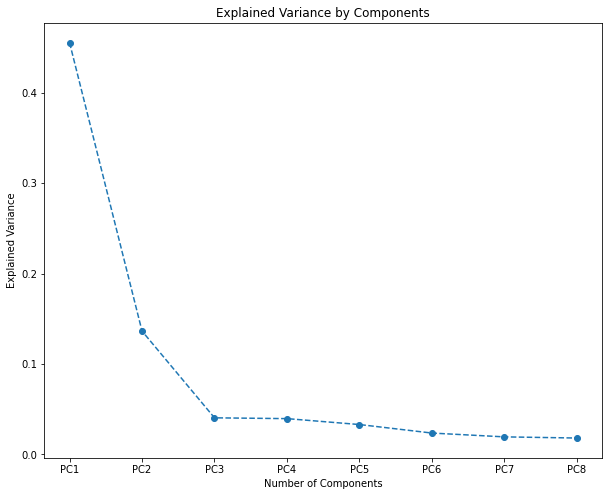

In [844]:
plt.figure(figsize = (10,8))
plt.plot(['PC'+str(i) for i in range(1,9)], pca.explained_variance_ratio_, marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')

In [653]:
pca = PCA(n_components = 3)
pca.fit(cluster)
scores_pca = pca.transform(cluster)

In [656]:
wcss = []
for i in range(1,21):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++',random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [657]:
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=20, random_state=42)

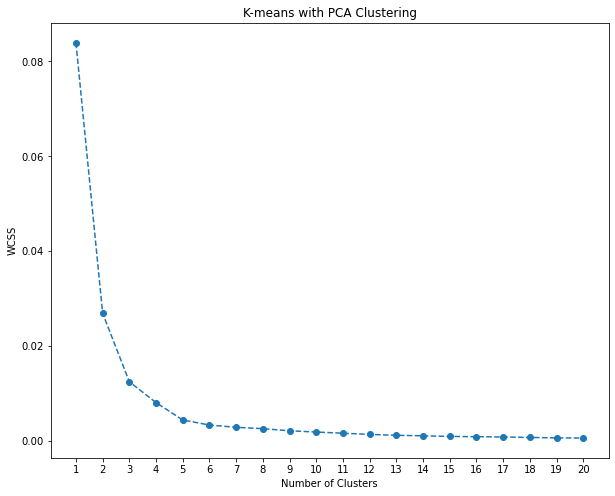

In [660]:
plt.figure(figsize = (10,8))
plt.plot([str(i) for i in range(1,21)], wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

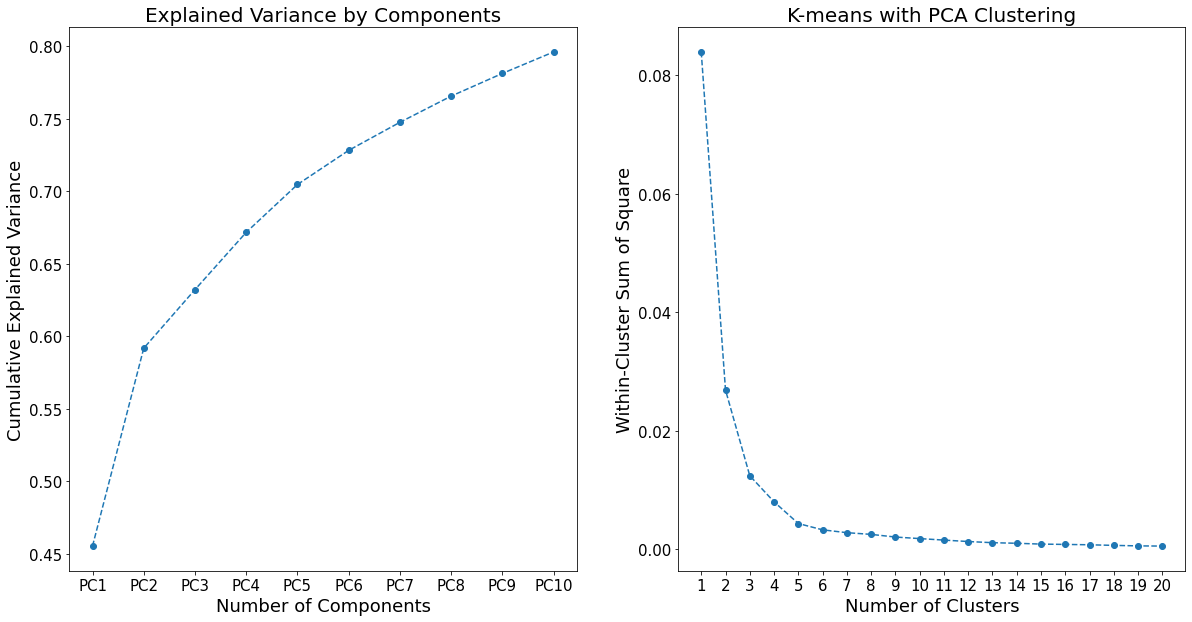

In [681]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.plot(['PC'+str(i) for i in range(1,11)], pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
ax1.set_title('Explained Variance by Components',fontsize=20)
ax1.set_xlabel('Number of Components',fontsize=18)
ax1.set_ylabel('Cumulative Explained Variance',fontsize=18)
ax1.yaxis.set_tick_params(labelsize=15)
ax1.xaxis.set_tick_params(labelsize=15)

ax2.plot([str(i) for i in range(1,21)], wcss, marker = 'o', linestyle = '--')
ax2.set_title('K-means with PCA Clustering',fontsize=20)
ax2.set_xlabel('Number of Clusters',fontsize=18)
ax2.set_ylabel("Within-Cluster Sum of Square",fontsize=18)
ax2.yaxis.set_tick_params(labelsize=15)
ax2.xaxis.set_tick_params(labelsize=15)

fig.savefig('../n_cluster_selection.png', dpi = 100)

And from this graph, we determine the number of clusters we’d like to keep. To that effect, we use the Elbow-method. The approach consists of looking for a kink or elbow in the WCSS graph. Usually, the part of the graph before the elbow would be steeply declining, while the part after it – much smoother. In this instance, we’ll be keeping a three-cluster solution.

In [662]:
kmeans_pca = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

In [663]:
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=3, random_state=42)

In [673]:
df_cluster_pca_kmeans = pd.concat([cluster.reset_index(), pd.DataFrame(scores_pca)], axis = 1)
df_cluster_pca_kmeans['Continent'] = df_cluster_pca_kmeans['Region Code'].apply(getContinentName)
df_cluster_pca_kmeans['Region Name'] = df_cluster_pca_kmeans['Region Code'].apply(getRegionName)

# Replace the abbreviation of continent with corresponding full names
df_cluster_pca_kmeans['Continent'] = df_cluster_pca_kmeans['Continent'].replace({'AS':'Asia', 'EU':'Europe', 'NA':'North America',
                                          'OC':'Oceania','SA':'South America'})

# Reduce the length of some region names
df_cluster_pca_kmeans['Region'] = df_cluster_pca_kmeans['Region Name'].replace({'Bolivia, Plurinational State of':'Bolivia', 
                                     'Taiwan, Province of China':'Taiwan',
                                     'United States':'United States of America'})

df_cluster_pca_kmeans.columns.values[-6:-3] = ['PC1','PC2','PC3']
# df_cluster_pca_kmeans.columns.values[-3:] = ['PC1','PC2','PC3']
df_cluster_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
df_cluster_pca_kmeans = df_cluster_pca_kmeans.loc[(df_cluster_pca_kmeans['Continent'] != 'Global')]
df_cluster_pca_kmeans

Region Code  #TocoParaVos Bailemos juntos  \
0           AR                      0.000000   
1           AT                      0.000000   
2           AU                      0.000000   
3           BE                      0.000000   
4           BO                      0.000000   
5           BR                      0.000000   
6           CA                      0.000000   
7           CH                      0.000000   
8           CL                      0.000000   
9           CO                      0.000000   
10          CR                      0.000000   
11          CZ                      0.000000   
12          DE                      0.000000   
13          DK                      0.000000   
14          DO                      0.000000   
15          EC                      0.000000   
16          EE                      0.000000   
17          ES                      0.000000   
18          FI                      0.000000   
19          FR                      0.000000   
20          GB                      0.000000   
22          GR                      0.000000   
23          GT                      0.000000   
24          HK                      0.000000   
25          HN                      0.000000   
26          HU                      0.000000   
27          ID                      0.000000   
28          IE                      0.000000   
29          IS                      0.000000   
30          IT                      0.000000   
31          JP                      0.000000   
32          LT                      0.000000   
33          LU                      0.000000   
34          LV                      0.000000   
35          MX                      0.000000   
36          MY                      0.000000   
37          NL                      0.000000   
38          NO                      0.000000   
39          NZ                      0.000000   
40          PA                      0.000000   
41          PE                      0.000000   
42          PH                      0.000000   
43          PL                      0.000000   
44          PT                      0.000000   
45          PY                      0.000000   
46          SE                      0.000000   
47          SG                      0.000000   
48          SK                      0.000000   
49          SV                      0.000000   
50          TR                      0.000000   
51          TW                      0.000000   
52          US                      0.000000   
53          UY                      0.000005   

    #TocoParaVos Enganchado #TocoParaVos - Cumbia Mix  \
0                                            0.000014   
1                                            0.000000   
2                                            0.000000   
3                                            0.000000   
4                                            0.000000   
5                                            0.000000   
6                                            0.000000   
7                                            0.000000   
8                                            0.000000   
9                                            0.000000   
10                                           0.000000   
11                                           0.000000   
12                                           0.000000   
13                                           0.000000   
14                                           0.000000   
15                                           0.000000   
16                                           0.000000   
17                                           0.000000   
18                                           0.000000   
19                                           0.000000   
20                                           0.000000   
22                                           0.000000   
23                                           0.000000   
24                                        

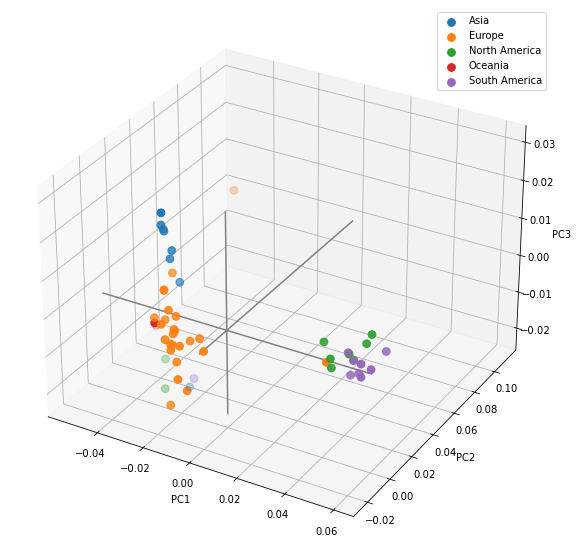

In [674]:
# Plot initialisation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

label = df_cluster_pca_kmeans['Continent']
uniq = np.unique(label)
for i in uniq:
   ax.scatter(df_cluster_pca_kmeans.PC1[label == i], 
              df_cluster_pca_kmeans.PC2[label == i], 
              df_cluster_pca_kmeans.PC3[label == i], 
              s=60, label = i)

# make simple, bare axis lines through space:
xAxisLine = ((min(df_cluster_pca_kmeans.PC1), max(df_cluster_pca_kmeans.PC1)), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'grey')
yAxisLine = ((0, 0), (min(df_cluster_pca_kmeans.PC2), max(df_cluster_pca_kmeans.PC2)), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'grey')
zAxisLine = ((0, 0), (0,0), (min(df_cluster_pca_kmeans.PC3), max(df_cluster_pca_kmeans.PC3)))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'grey')

# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()

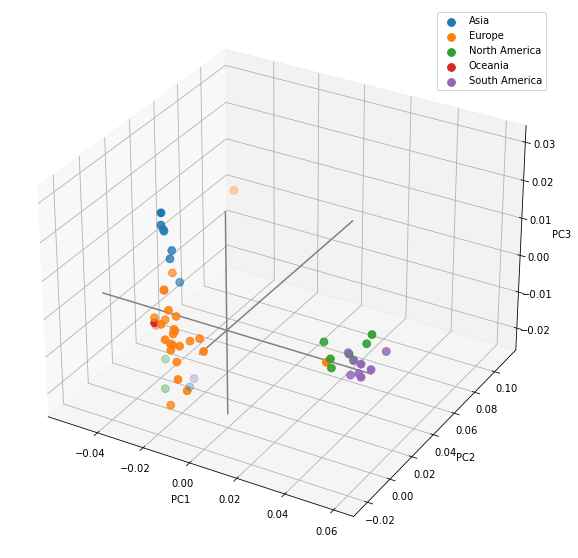

In [636]:
# Plot initialisation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

label = pca_results['Continent']
uniq = np.unique(label)
for i in uniq:
   ax.scatter(pca_results.f1[label == i], 
               pca_results.f2[label == i], 
               pca_results.f3[label == i], 
               s=60, label = i)

# make simple, bare axis lines through space:
xAxisLine = ((min(pca_results.f1), max(pca_results.f1)), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'grey')
yAxisLine = ((0, 0), (min(pca_results.f2), max(pca_results.f2)), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'grey')
zAxisLine = ((0, 0), (0,0), (min(pca_results.f3), max(pca_results.f3)))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'grey')

# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()

In [375]:
# Calculate 2 PCA components for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(cluster)
Region_code = cluster.index
pca_results = pd.DataFrame(pca_features, columns=['f1', 'f2'])
pca_results['Region Code'] = Region_code
pca_results['Continent'] = pca_results['Region Code'].apply(getContinentName)
pca_results['Region Name'] = pca_results['Region Code'].apply(getRegionName)

# Replace the abbreviation of continent with corresponding full names
pca_results['Continent'] = pca_results['Continent'].replace({'AS':'Asia', 'EU':'Europe', 'NA':'North America',
                                          'OC':'Oceania','SA':'South America'})

# Reduce the length of some region names
pca_results['Region'] = pca_results['Region Name'].replace({'Bolivia, Plurinational State of':'Bolivia', 
                                     'Taiwan, Province of China':'Taiwan',
                                     'United States':'United States of America'})

pca_results =  pca_results.loc[(pca_results['Continent'] != 'Global')]
pca_results

f1        f2 Region Code      Continent  \
0   0.053687  0.002267          AR  South America   
1  -0.019797 -0.006728          AT         Europe   
2  -0.024785 -0.011558          AU        Oceania   
3  -0.021072 -0.003217          BE         Europe   
4   0.059860  0.012930          BO  South America   
5  -0.002579 -0.022316          BR  South America   
6  -0.021079 -0.010443          CA  North America   
7  -0.016166  0.000599          CH         Europe   
8   0.055789 -0.000266          CL  South America   
9   0.047901  0.005299          CO  South America   
10  0.037829  0.005583          CR  North America   
11 -0.023241 -0.003121          CZ         Europe   
12 -0.016980 -0.008979          DE         Europe   
13 -0.018319 -0.011132          DK         Europe   
14  0.043306  0.000647          DO  North America   
15  0.050828  0.003801          EC  South America   
16 -0.039600  0.030984          EE         Europe   
17  0.038565  0.006333          ES         Europe   
18 -0.011396 -0.018725          FI         Europe   
19 -0.008883 -0.016188          FR         Europe   
20 -0.021916 -0.008890          GB         Europe   
22 -0.032295  0.010697          GR         Europe   
23  0.049307  0.003102          GT  North America   
24 -0.017737 -0.011216          HK           Asia   
25  0.051855  0.013003          HN  North America   
26 -0.023489  0.003274          HU         Europe   
27 -0.021793 -0.010236          ID           Asia   
28 -0.024253 -0.007405          IE         Europe   
29 -0.021297 -0.006700          IS         Europe   
30 -0.006379 -0.007018          IT         Europe   
31 -0.015857 -0.007355          JP           Asia   
32 -0.035285  0.015842          LT         Europe   
33 -0.053578  0.111917          LU         Europe   
34 -0.035011  0.007003          LV         Europe   
35  0.042573  0.001269          MX  North America   
36 -0.021545 -0.008346          MY           Asia   
37 -0.015165 -0.009828          NL         Europe   
38 -0.020128 -0.008084          NO         Europe   
39 -0.024281 -0.011401          NZ        Oceania   
40  0.048884  0.008174          PA  North America   
41  0.054678  0.002008          PE  South America   
42 -0.019425 -0.014238          PH           Asia   
43 -0.019937 -0.004517          PL         Europe   
44 -0.012165  0.000863          PT         Europe   
45  0.058047  0.003589          PY  South America   
46 -0.020454 -0.004950          SE         Europe   
47 -0.023350 -0.005572          SG           Asia   
48 -0.033020  0.011556          SK         Europe   
49  0.053292  0.014469          SV  North America   
50 -0.011067 -0.009967          TR           Asia   
51 -0.017630 -0.009860          TW           Asia   
52 -0.017242 -0.018220          US  North America   
53  0.050930  0.001085          UY  South America   

                        Region Name                    Region  
0                         Argentina                 Argentina  
1                           Austria                   Austria  
2                         Australia                 Australia  
3                           Belgium                   Belgium  
4   Bolivia, Plurinational State of                   Bolivia  
5                            Brazil                    Brazil  
6                            Canada                    Canada  
7                       Switzerland               Switzerland  
8                             Chile                     Chile  
9                          Colombia                  Colombia  
10                       Costa Rica                Costa Rica  
11                          Czechia                   Czechia  
12                          Germany                   Germany  
13                          Denmark                   Denmark  
14               Dominican Republic        Dominican Republic  
15                          Ecuador                   Ecuador  
16                          Estonia                   Eston

Text(0.5, 1.0, 'PCA two-dimensional features')

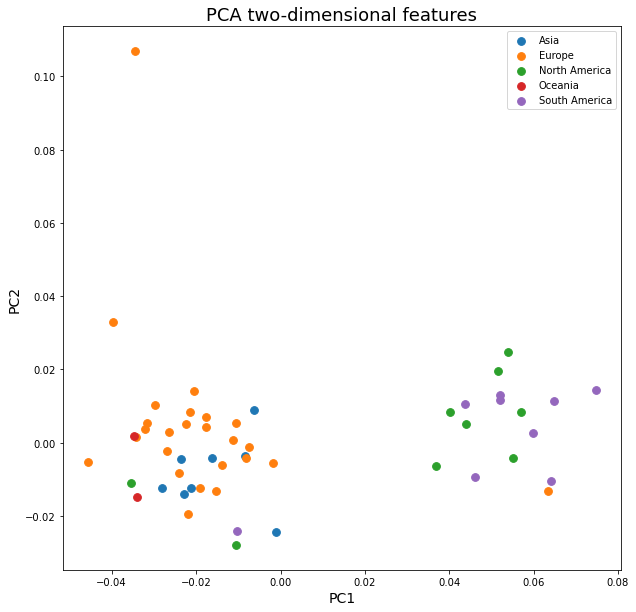

In [376]:
# visualize the 2 PCA components
mpl.rcParams['figure.figsize'] = (10, 10)

# Add randomness to jittering the points slighty to advoid overlaped scatter plot
pca_results['PC1'] = pca_results.f1 + np.random.normal(0, 0.008, len(pca_results.f1))
pca_results['PC2'] = pca_results.f2 + np.random.normal(0, 0.008, len(pca_results.f2))
# ax = pca_results.plot('f1', 'f2', kind='scatter')
# pca_results[['f1','f2','Continent']].apply(lambda x: ax.text(*x, rotation=30),axis=1)
# plt.title('PCA two-dimensional features')

label = pca_results['Continent']
uniq = np.unique(label)
for i in uniq:
   plt.scatter(pca_results['PC1'][label == i], pca_results['PC2'][label == i], s=60, label = i)
plt.ylabel('PC2', size=14)
plt.xlabel('PC1', size=14)
plt.legend()
plt.title('PCA two-dimensional features', size=18)

This chart runs PCA on the features to be able to visualize the features in two dimensions. It divide the data into about two clusters. It's clear that Latin American Spanish speaking regions have similar characteristics and are clustered together. Arguably there is also an European cluster of some sort.

### For each cluster

In [377]:
pca_results

f1        f2 Region Code      Continent  \
0   0.053687  0.002267          AR  South America   
1  -0.019797 -0.006728          AT         Europe   
2  -0.024785 -0.011558          AU        Oceania   
3  -0.021072 -0.003217          BE         Europe   
4   0.059860  0.012930          BO  South America   
5  -0.002579 -0.022316          BR  South America   
6  -0.021079 -0.010443          CA  North America   
7  -0.016166  0.000599          CH         Europe   
8   0.055789 -0.000266          CL  South America   
9   0.047901  0.005299          CO  South America   
10  0.037829  0.005583          CR  North America   
11 -0.023241 -0.003121          CZ         Europe   
12 -0.016980 -0.008979          DE         Europe   
13 -0.018319 -0.011132          DK         Europe   
14  0.043306  0.000647          DO  North America   
15  0.050828  0.003801          EC  South America   
16 -0.039600  0.030984          EE         Europe   
17  0.038565  0.006333          ES         Europe   
18 -0.011396 -0.018725          FI         Europe   
19 -0.008883 -0.016188          FR         Europe   
20 -0.021916 -0.008890          GB         Europe   
22 -0.032295  0.010697          GR         Europe   
23  0.049307  0.003102          GT  North America   
24 -0.017737 -0.011216          HK           Asia   
25  0.051855  0.013003          HN  North America   
26 -0.023489  0.003274          HU         Europe   
27 -0.021793 -0.010236          ID           Asia   
28 -0.024253 -0.007405          IE         Europe   
29 -0.021297 -0.006700          IS         Europe   
30 -0.006379 -0.007018          IT         Europe   
31 -0.015857 -0.007355          JP           Asia   
32 -0.035285  0.015842          LT         Europe   
33 -0.053578  0.111917          LU         Europe   
34 -0.035011  0.007003          LV         Europe   
35  0.042573  0.001269          MX  North America   
36 -0.021545 -0.008346          MY           Asia   
37 -0.015165 -0.009828          NL         Europe   
38 -0.020128 -0.008084          NO         Europe   
39 -0.024281 -0.011401          NZ        Oceania   
40  0.048884  0.008174          PA  North America   
41  0.054678  0.002008          PE  South America   
42 -0.019425 -0.014238          PH           Asia   
43 -0.019937 -0.004517          PL         Europe   
44 -0.012165  0.000863          PT         Europe   
45  0.058047  0.003589          PY  South America   
46 -0.020454 -0.004950          SE         Europe   
47 -0.023350 -0.005572          SG           Asia   
48 -0.033020  0.011556          SK         Europe   
49  0.053292  0.014469          SV  North America   
50 -0.011067 -0.009967          TR           Asia   
51 -0.017630 -0.009860          TW           Asia   
52 -0.017242 -0.018220          US  North America   
53  0.050930  0.001085          UY  South America   

                        Region Name                    Region       PC1  \
0                         Argentina                 Argentina  0.052035   
1                           Austria                   Austria -0.019156   
2                         Australia                 Australia -0.034114   
3                           Belgium                   Belgium -0.045557   
4   Bolivia, Plurinational State of                   Bolivia  0.064772   
5                            Brazil                    Brazil -0.010225   
6                            Canada                    Canada -0.035499   
7                       Switzerland               Switzerland -0.020573   
8                             Chile                     Chile  0.064127   
9                          Colombia                  Colombia  0.043668   
10                       Costa Rica                Costa Rica  0.040188   
11                          Czechia                   Czechia -0.026967   
12                          Germany                   Germany -0.013902   
13                          Denmark                   Denmark -0.024090   
14               Domin

In [388]:
### Select ranges for the three major clusters

# GroupA represent Eurasia continent
groupA = pca_results[(pca_results['PC2'] <= 0.04) & (pca_results['PC1'] < 0.02)]

# GroupB represent America continent
groupB = pca_results[pca_results['PC1'] > 0.02] 

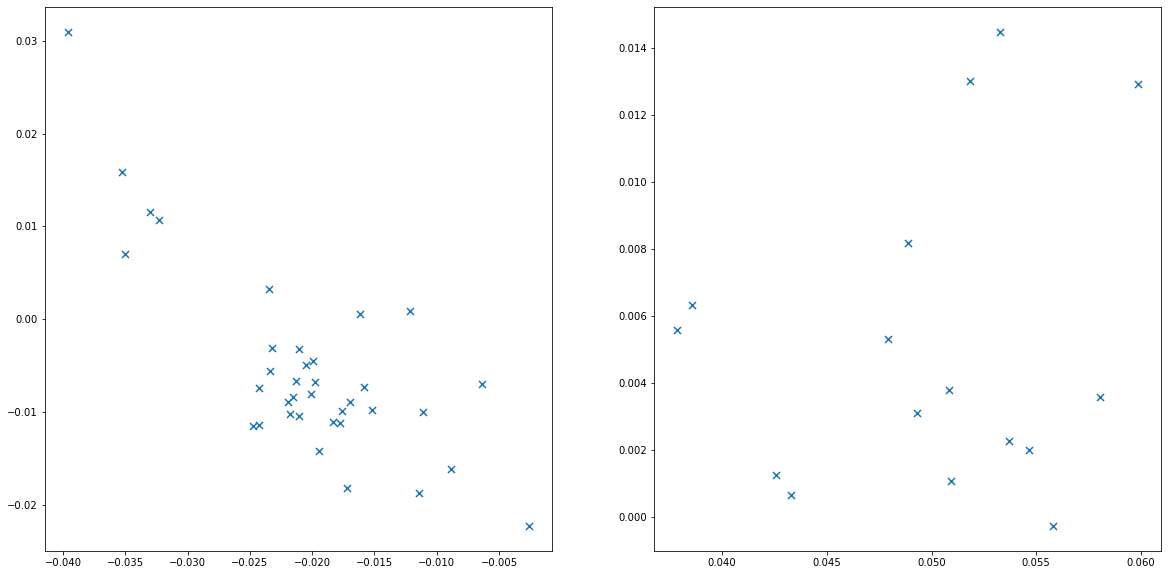

In [589]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.scatter(groupA['f1'], groupA['f2'], s=50, marker='x')
# groupA['f1','f2','Region']].apply(lambda x: ax1.text(*x, rotation=30, fontsize=10),axis=1)

ax2.scatter(groupB['f1'], groupB['f2'], s=50, marker='x')
# groupB['f1','f2','Region']].apply(lambda x: ax2.text(*x),axis=1)



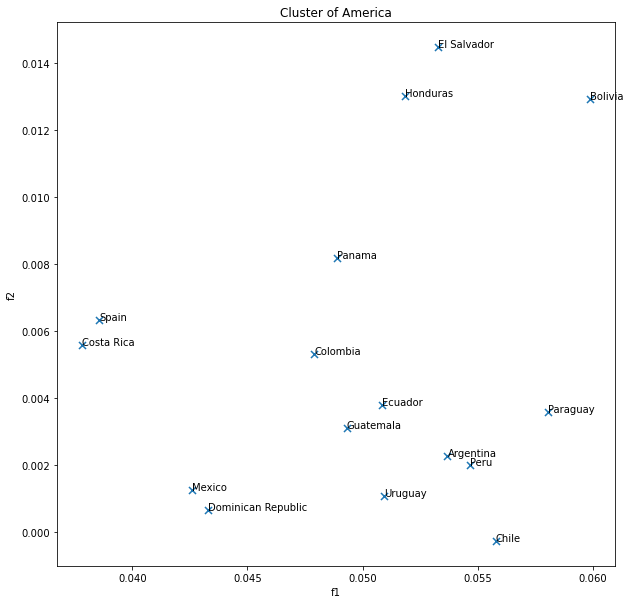

In [390]:
ax = groupB.plot('f1', 'f2', kind='scatter', s=50, marker='x')
groupB[['f1','f2','Region']].apply(lambda x: ax.text(*x),axis=1)
plt.title('Cluster of America')
plt.savefig('GroupA.png')

Text(0.5, 1.0, 'Cluster of Eurasia')

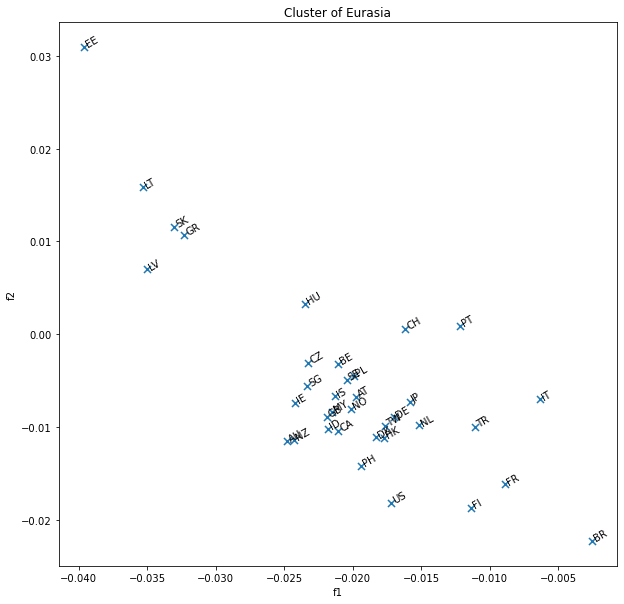

In [393]:
# ax = groupB.plot('f1', 'f2', kind='scatter', s=50, marker='x')
# groupB[['f1','f2','Region']].apply(lambda x: ax.text(*x),axis=1);
# plt.title('Cluster of Eurasia')
ax = groupA.plot('f1', 'f2', kind='scatter', s=50, marker='x')
groupA[['f1','f2','Region Code']].apply(lambda x: ax.text(*x, rotation=30, fontsize=10),axis=1)
plt.title('Cluster of Eurasia')

### K means with PCA